In [863]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d
import yfinance as yf
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar
from scipy.integrate import trapz
from scipy.misc import derivative
from scipy.integrate import simps
from scipy.optimize import curve_fit
import math
from scipy.integrate import solve_ivp

Spot price of underlying = 332

In [668]:
calls = pd.read_excel("SPY_191020exp_290920.xlsx", sheet_name="call")
calls["midprice"] = (calls.bid + calls.ask)/2
calls = calls[calls.midprice > 0]
calls

,strike,lastPrice,change,bid,ask,BxA,volume,openInterest,midprice
0,170,0.00,0.0,163.70,164.06,146 x 146,0,0,163.880
1,175,0.00,0.0,158.70,159.06,146 x 146,0,0,158.880
2,180,0.00,0.0,153.69,154.05,146 x 102,0,0,153.870
3,185,0.00,0.0,148.70,149.04,146 x 102,0,0,148.870
4,190,0.00,0.0,143.70,144.06,146 x 146,0,0,143.880
...,...,...,...,...,...,...,...,...,...
110,405,0.01,0.0,0.00,0.01,0 x 11065,0,28,0.005
111,410,0.02,0.0,0.00,0.01,0 x 8620,0,200,0.005
112,415,0.01,0.0,0.00,0.01,0 x 8630,0,5,0.005
113,420,0.02,0.0,0.00,0.01,0 x 8641,0,55,0.005


In [669]:
calls.iloc[74]

strike                342
lastPrice            0.87
change              -0.14
bid                  0.87
ask                  0.88
BxA             250 x 131
volume                191
openInterest        11182
midprice            0.875
Name: 74, dtype: object

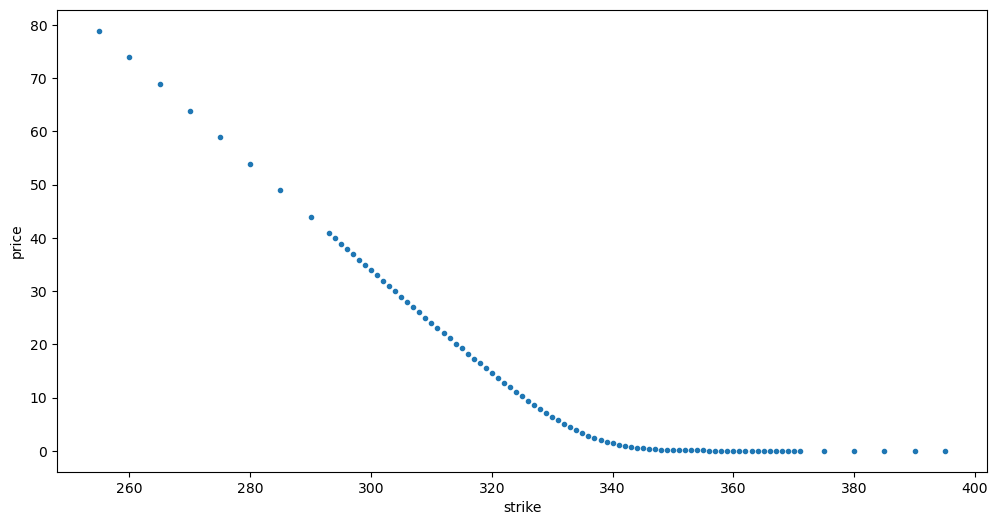

In [670]:
calls_sub = calls[(calls.strike > 250) & (calls.strike < 400)]
plt.figure(figsize=(12,6))
plt.plot(calls_sub.strike, calls_sub.midprice, ".");
plt.xlabel("strike")
plt.ylabel("price")
#plt.savefig("call_prices.png", dpi=400)
plt.show()

## Implied Volatility Surface

In [671]:
def call_value(S, K, sigma, t=0, r=0):
    # use np.multiply and divide to handle divide-by-zero
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
        d2 = d1 - sigma * np.sqrt(t)
    return np.multiply(norm.cdf(d1),S) - np.multiply(norm.cdf(d2), K * np.exp(-r * t))

def call_vega(S, K, sigma, t=0, r=0):
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
    return np.multiply(S, norm.pdf(d1)) * np.sqrt(t)

def bs_iv(price, S, K, t=0, r=0, precision=1e-4, initial_guess=0.2, max_iter=1000, verbose=False):
    iv = initial_guess
    for _ in range(max_iter):
        P = call_value(S, K, iv, t, r)
        diff = price - P
        if abs(diff) < precision:
            return iv
        grad = call_vega(S, K, iv, t, r)
        iv += diff/grad     
    if verbose:
        print(f"Did not converge after {max_iter} iterations")
    return iv 

In [672]:
S = 332
t = 3/52
calls["iv"] = calls.apply(lambda row: bs_iv(row.midprice, S, row.strike, t, max_iter=500), axis=1)

C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_14692\2692504730.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  iv += diff/grad
C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_14692\2692504730.py:4: RuntimeWarning: invalid value encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_14692\2692504730.py:10: RuntimeWarning: invalid value encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)


In [673]:
def plot_vol_smile(calls, savefig=False):
    plt.figure(figsize=(9,6))
    plt.plot(calls.strike, calls.iv, ".")
    plt.xlabel("Strike")
    plt.ylabel("IV")
    if savefig:
        plt.savefig("vol_smile.png",dpi=300)
    plt.show()

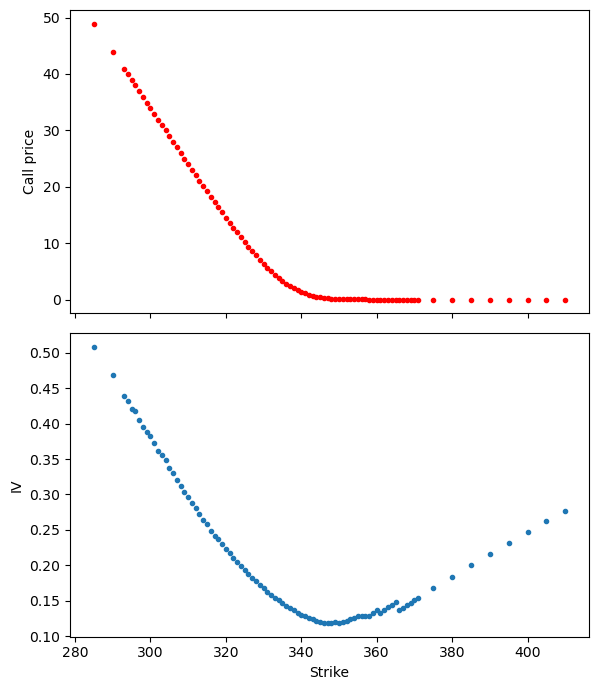

In [674]:
calls_no_na = calls.dropna()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,7), sharex=True)
ax1.plot(calls_no_na.strike, calls_no_na.midprice, "r.")
ax1.set_ylabel("Call price")
ax2.plot(calls_no_na.strike, calls_no_na.iv, ".")
ax2.set_ylabel("IV")
ax2.set_xlabel("Strike")
plt.tight_layout()
# plt.savefig("calls_to_iv.png", dpi=400)
plt.show()

In [675]:
calls_clean = calls.dropna().copy()
calls_clean["iv"] = gaussian_filter1d(calls_clean.iv, 3)

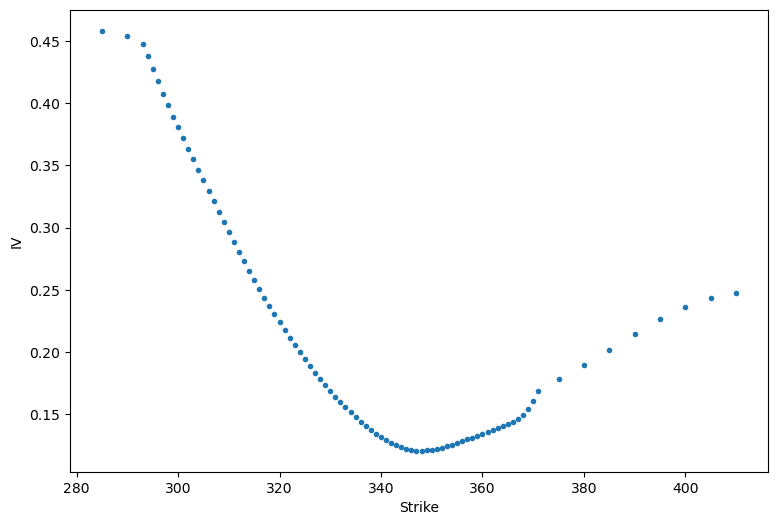

In [676]:
plot_vol_smile(calls_clean)

In [677]:
calls_clean = calls_clean[(calls_clean.strike > 300) & (calls_clean.strike < 375)]

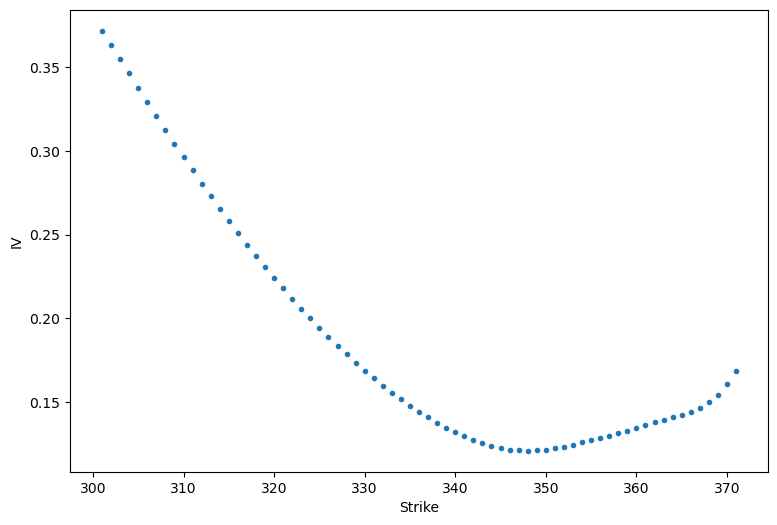

In [678]:
plot_vol_smile(calls_clean, savefig=False)

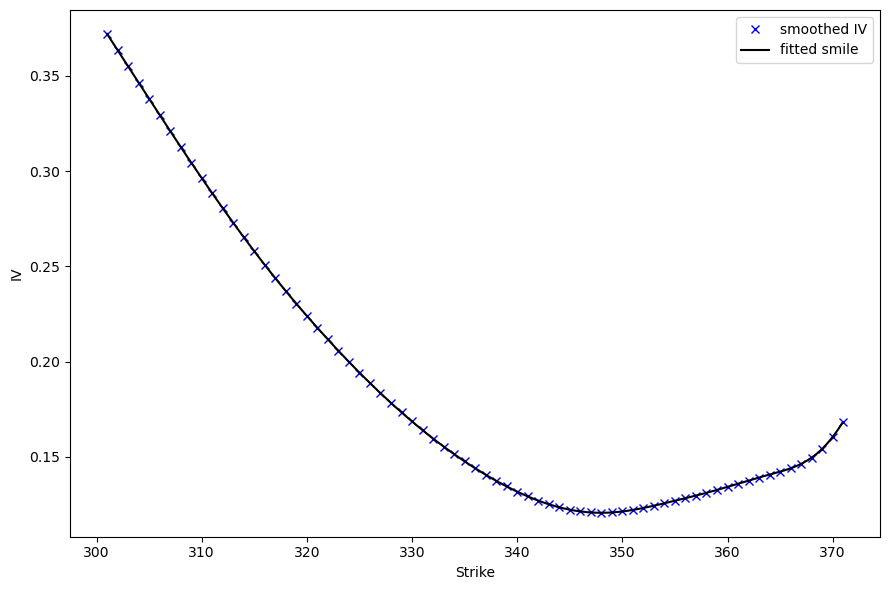

In [679]:
plt.figure(figsize=(9,6))
vol_surface = scipy.interpolate.interp1d(calls_clean.strike, calls_clean.iv, kind="cubic",
                                 fill_value="extrapolate")
x_new = np.arange(calls_clean.strike.min(), calls_clean.strike.max(), 0.1)
plt.plot(calls_clean.strike, calls_clean.iv, "bx", x_new, vol_surface(x_new), "k-");
plt.legend(["smoothed IV", "fitted smile"], loc="best")
plt.xlabel("Strike")
plt.ylabel("IV")
plt.tight_layout()
# plt.savefig("SPY_smile.png", dpi=300)
plt.show()

In [680]:
C_interp = call_value(S, x_new, vol_surface(x_new), t)

In [681]:
first_deriv = np.gradient(C_interp, x_new)
second_deriv = np.gradient(first_deriv, x_new)

In [682]:
def pdf(Krange, S, t=0, r=0):
    # x is a range of strikes
    Crange = call_value(S, Krange, vol_surface(Krange), t, r)
    first_deriv = np.gradient(Crange, x_new, edge_order=0)
    second_deriv = np.gradient(first_deriv, x_new, edge_order=0)
    return np.exp(r * t) * second_deriv

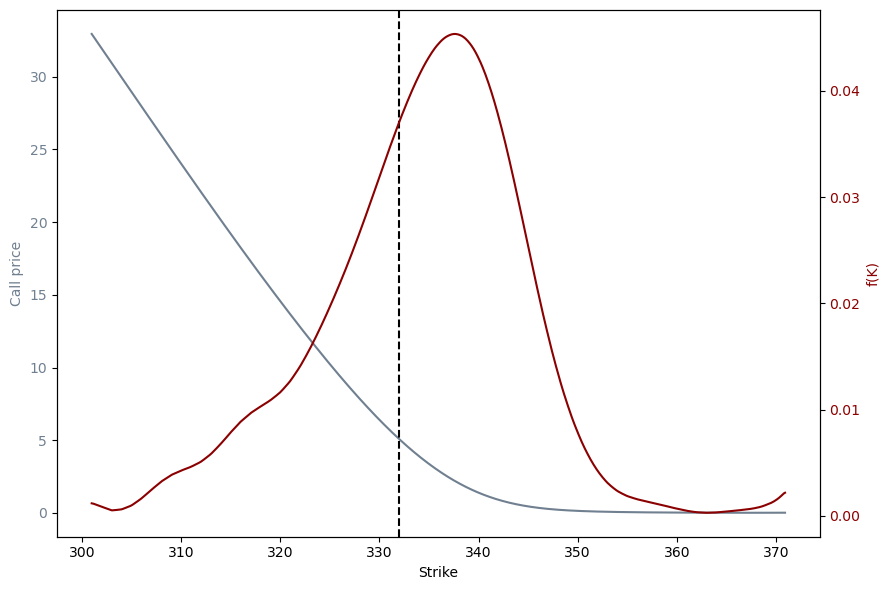

In [683]:
fig, ax1 = plt.subplots(figsize=(9,6))

col="slategrey"
ax1.set_xlabel('Strike')
ax1.set_ylabel('Call price', color=col)
ax1.plot(x_new, C_interp, color=col)
ax1.tick_params(axis='y', labelcolor=col)
ax1.axvline(332, color="k", linestyle="--")

ax2 = ax1.twinx()
col = 'darkred'
ax2.set_ylabel('f(K)', color=col)
ax2.plot(x_new, pdf(x_new, S, t), color=col)
ax2.tick_params(axis='y', labelcolor=col)

fig.tight_layout()
# plt.savefig("volspace_pdf.png", dpi=300)
plt.show()

In [684]:
data = np.vstack([x_new, pdf(x_new, S, t)]).T
data = data[(data[:, 0] < 360) & (data[:, 0] > 320)]
k, curve_pdf = np.hsplit(data, 2)

#### Create 2D array

In [685]:
# Flatten the arrays if they are 2D
k_flat = k.flatten()
curve_pdf_flat = curve_pdf.flatten()

# Create a 2D array for the original PDF
original_pdf = np.column_stack((k_flat, curve_pdf_flat))

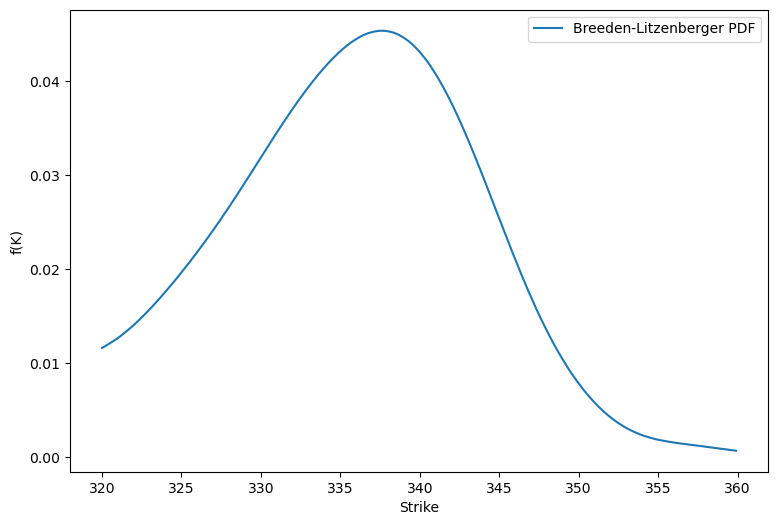

In [686]:
plt.figure(figsize=(9,6))
plt.plot(original_pdf[:, 0], original_pdf[:, 1])

# plt.savefig("breeden_litzenberger_pdf.png", dpi=300)

plt.xlabel("Strike")
plt.ylabel("f(K)")
plt.legend(["Breeden-Litzenberger PDF"], loc="best")
plt.show()


C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_14692\3535132552.py:7: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * (x - c))


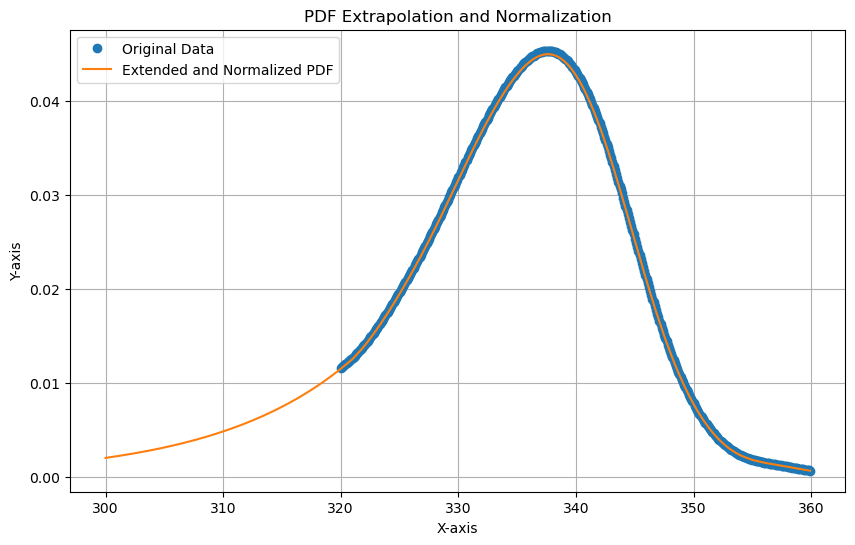

In [687]:

# Separate the original data into x and y components for clarity
x_original = original_pdf[:, 0]
y_original = original_pdf[:, 1]

# Define the exponential decay function
def exp_decay(x, a, b, c):
    return a * np.exp(-b * (x - c))

# Use the leftmost points of the original data to fit the exponential decay
left_points_x = x_original[:10]  # Use more points if necessary for a better fit
left_points_y = y_original[:10]
params, _ = curve_fit(exp_decay, left_points_x, left_points_y, p0=(1, 1, x_original[0]))

# Define the range for extrapolation
x_min_extrapolate = 300  # Adjust this as needed

# Generate new x values for extrapolation
x_extrapolate = np.linspace(x_min_extrapolate, x_original[0], num=100, endpoint=False)

# Generate new y values using the fitted exponential decay
y_extrapolate = exp_decay(x_extrapolate, *params)

# Combine the extrapolated points with the original data
extrapolated_pdf = np.column_stack((x_extrapolate, y_extrapolate))
new_pdf = np.vstack((extrapolated_pdf, original_pdf))

# Normalize the curve so the total area is 1
x_values = new_pdf[:, 0]
y_values = new_pdf[:, 1]
area = simps(y_values, x_values)
y_values_normalized = y_values / area

# Replace the y-values in new_pdf with normalized values
new_pdf[:, 1] = y_values_normalized

# Plot the original and the new PDF
plt.figure(figsize=(10, 6))
plt.plot(x_original, y_original, 'o', label='Original Data')
plt.plot(new_pdf[:, 0], new_pdf[:, 1], label='Extended and Normalized PDF')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('PDF Extrapolation and Normalization')
plt.legend()
plt.grid(True)
plt.show()


In [688]:
rn_pdf = new_pdf

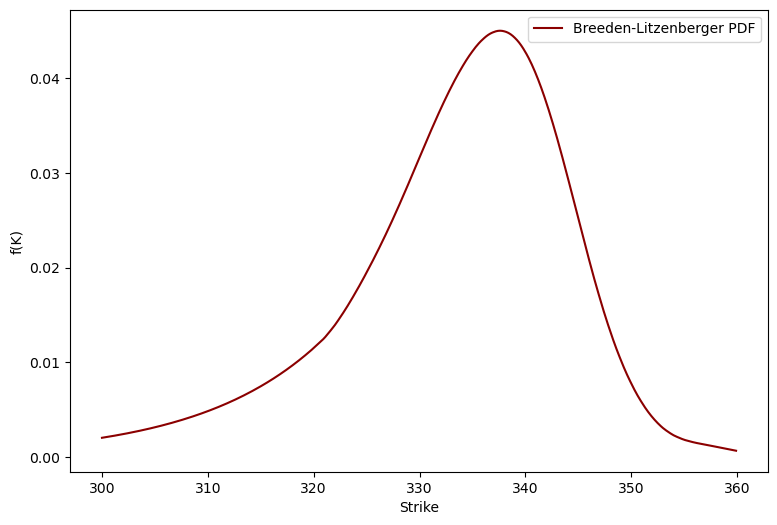

In [689]:
plt.figure(figsize=(9,6))
plt.plot(rn_pdf[:, 0], rn_pdf[:, 1], "darkred")
plt.xlabel("Strike")
plt.ylabel("f(K)")
plt.legend(["Breeden-Litzenberger PDF"], loc="best")
# plt.savefig("breeden_litzenberger_pdf.png", dpi=300)
plt.show()


### Define payoffs and useful functions

In [690]:
def reverse_convertible(x,K):
    if x <= K:
        return x
    else:
        return K 

In [691]:
def reverse_convertible_payoff(S_T, S_0, P, C, K):
    """
    Calculates the payoff of a reverse convertible.

    Parameters:
    S_T: Price of the underlying asset at maturity.
    S_0: Initial price of the underlying asset.
    P: Principal amount.
    C: Coupon payment.
    K: Strike price.

    Returns:
    Total payoff of the reverse convertible.
    """
    # Adjusted asset value based on the initial price
    adjusted_asset_value = P * S_T / S_0

    # The investor receives the adjusted asset value if it's below the principal, 
    # otherwise they receive the principal amount.
    asset_or_principal = min(P, adjusted_asset_value)

    # Total payoff is the sum of the coupon payment and the minimum of principal or adjusted asset value.
    return C + asset_or_principal

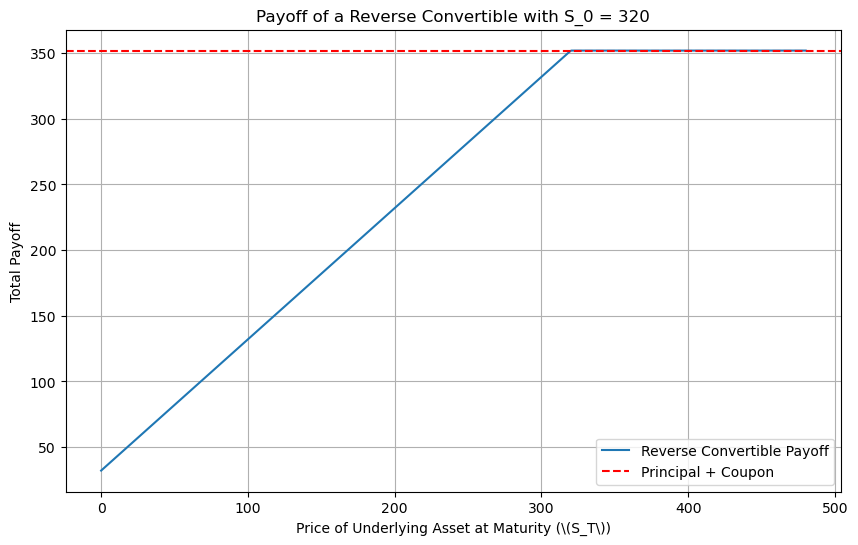

In [692]:
##PLOT EXAMPLE 

# Parameters
S_0 = 320  # Initial price of the underlying asset
P = S_0  # Principal amount (equal to S_0)
C = P * 0.10  # Coupon payment (10% of principal)
K = P  # Strike price equal to the principal

# Price of the underlying asset at maturity ranging from 0 to 1.5 times the initial price
S_T_values = np.linspace(0, 1.5 * S_0, 500)

# Calculate payoffs
payoffs = [reverse_convertible_payoff(S_T, S_0, P, C, K) for S_T in S_T_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(S_T_values, payoffs, label='Reverse Convertible Payoff')
plt.axhline(y=P + C, color='r', linestyle='--', label='Principal + Coupon')
plt.title('Payoff of a Reverse Convertible with S_0 = 320')
plt.xlabel('Price of Underlying Asset at Maturity (\(S_T\))')
plt.ylabel('Total Payoff')
plt.legend()
plt.grid(True)
plt.show()


In [693]:
def european_barrier_reverse_convertible_payoff(S_T, S_0, P, C, K, B):
    """
    Calculates the payoff of a European-style barrier reverse convertible.

    Parameters:
    S_T: Price of the underlying asset at maturity.
    S_0: Initial price of the underlying asset.
    P: Principal amount.
    C: Coupon payment.
    K: Strike price.
    B: Barrier level.

    Returns:
    Total payoff of the European-style barrier reverse convertible.
    """
    # Check if the barrier was breached at maturity
    barrier_breached = S_T < B

    if barrier_breached:
        # Adjusted asset value based on the initial price
        adjusted_asset_value = P * S_T / S_0

        # The investor receives the adjusted asset value if it's below the principal, 
        # otherwise, they receive the principal amount.
        asset_or_principal = min(P, adjusted_asset_value)
    else:
        # If the barrier was not breached at maturity, the investor receives the principal.
        asset_or_principal = P

    # Total payoff is the sum of the coupon payment and the minimum of principal or adjusted asset value.
    return C + asset_or_principal

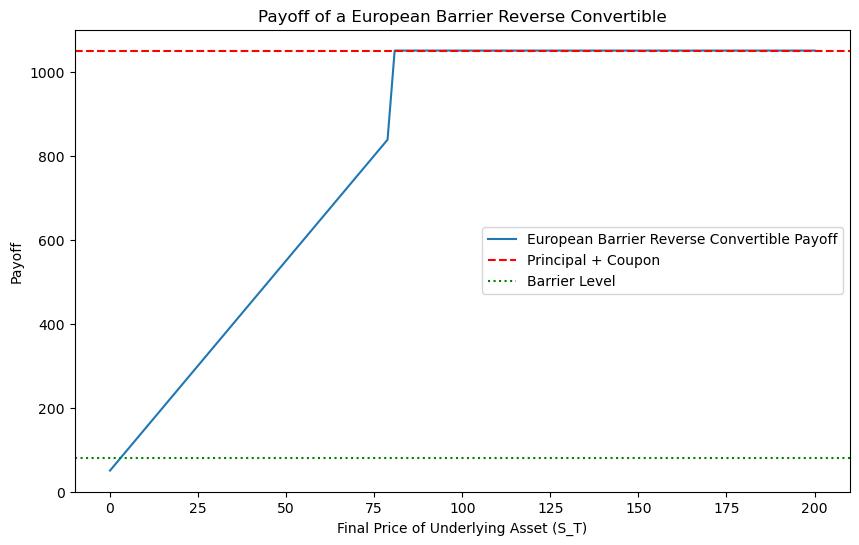

In [694]:
def plot_european_barrier_reverse_convertible_payoff(S_0, P, C, K, B):
    # Simulate a range of final prices
    S_T_values = np.linspace(0, 2 * S_0, 100)
    
    # Calculate payoffs
    payoffs = [european_barrier_reverse_convertible_payoff(S_T, S_0, P, C, K, B) for S_T in S_T_values]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(S_T_values, payoffs, label='European Barrier Reverse Convertible Payoff')
    plt.axhline(y=P+C, color='r', linestyle='--', label='Principal + Coupon')
    plt.axhline(y=B, color='g', linestyle=':', label='Barrier Level')
    plt.xlabel('Final Price of Underlying Asset (S_T)')
    plt.ylabel('Payoff')
    plt.title('Payoff of a European Barrier Reverse Convertible')
    plt.legend()
    plt.show()

# Example usage
plot_european_barrier_reverse_convertible_payoff(S_0=100, P=1000, C=50, K=100, B=80)

In [695]:
#Function that is equal to F'(x)/F(x) for the reverse convertible
def derivative_to_payoff_ratio_rc(S_T, S_0, P, C, K):
    """
    Calculates the ratio of the derivative of the reverse convertible payoff 
    to the payoff itself.

    Parameters:
    S_T: Price of the underlying asset at maturity.
    S_0: Initial price of the underlying asset.
    P: Principal amount.
    C: Coupon payment.
    K: Strike price.

    Returns:
    Ratio of the derivative of the payoff to the payoff itself.
    """
    # Calculate the reverse convertible payoff
    payoff = reverse_convertible_payoff(S_T, S_0, P, C, K)

    # Derivative is 1 before the strike and 0 after
    derivative = 1 if S_T < K else 0

    # Avoid division by zero
    if payoff == 0:
        return 0

    # Ratio calculation
    ratio = derivative / payoff if S_T < K else 0

    return ratio


In [696]:
#Function that is equal to F'(x)/F(x) for the barrier reverse convertible
def derivative_to_payoff_ratio_brc(S_T, S_0, P, C, K, B):
    """
    Calculates the ratio of the derivative of the European Barrier Reverse Convertible payoff 
    to the payoff itself.

    Parameters:
    S_T: Price of the underlying asset at maturity.
    S_0: Initial price of the underlying asset.
    P: Principal amount.
    C: Coupon payment.
    K: Strike price.
    B: Barrier level.

    Returns:
    Ratio of the derivative of the payoff to the payoff itself.
    """
    # Calculate the European Barrier Reverse Convertible payoff
    payoff = european_barrier_reverse_convertible_payoff(S_T, S_0, P, C, K, B)

    # Derivative is P/S_0 before the barrier and 0 after the barrier
    derivative = 1 if S_T < B else 0

    # Avoid division by zero
    if payoff == 0:
        return 0

    # Ratio calculation
    ratio = derivative / payoff if S_T < B else 0

    return ratio


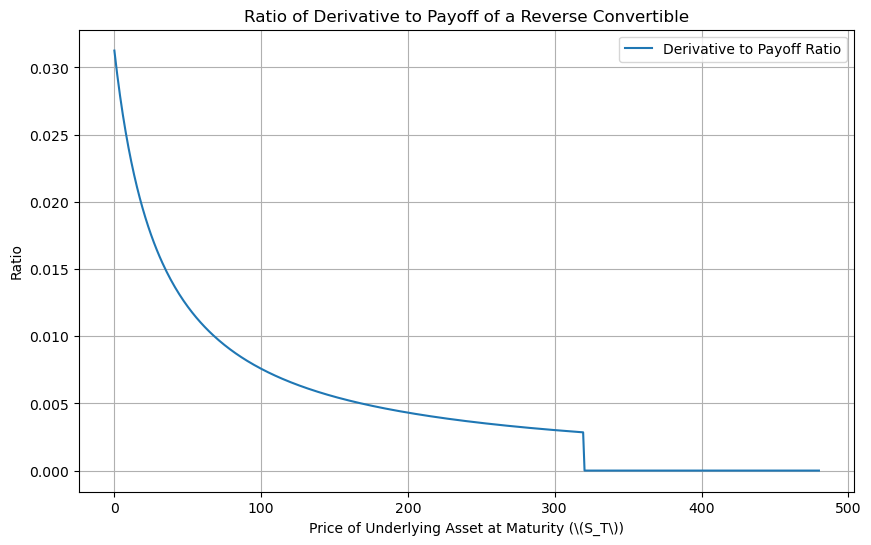

In [697]:
# Plotting the ratio for the same range of S_T values
ratio_values = [derivative_to_payoff_ratio_rc(S_T, S_0, P, C, K) for S_T in S_T_values]

plt.figure(figsize=(10, 6))
plt.plot(S_T_values, ratio_values, label='Derivative to Payoff Ratio')
plt.title('Ratio of Derivative to Payoff of a Reverse Convertible')
plt.xlabel('Price of Underlying Asset at Maturity (\(S_T\))')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True)
plt.show()


In [698]:

def ratio_function(x, growth_optimizer_payoff):
    # Function to compute the derivative
    def derivative_of_growth_optimizer(x):
        return derivative(growth_optimizer_payoff, x, dx=1e-6)
    
    # Function to compute the ratio of the original function to its derivative
    original_value = growth_optimizer_payoff(x)
    derivative_value = derivative_of_growth_optimizer(x)
    return original_value / derivative_value if derivative_value != 0 else np.inf

In [699]:
def relative_risk_aversion(x, growth_optimizer_payoff, general_payoff_ratio):
    return ratio_function(x, growth_optimizer_payoff) * general_payoff_ratio(x)

# Change pdf beliefs

In [763]:
#Measure the area under the pdf curves

def compute_area(pdf_array):
    """
    Compute the area under a given PDF represented as a 2D array.

    Parameters:
    pdf_array (numpy.ndarray): A 2D array where the first column contains the x-values (e.g., strike prices)
                               and the second column contains the corresponding PDF values.

    Returns:
    float: The area under the PDF curve.
    """
    x_values = pdf_array[:, 0]
    pdf_values = pdf_array[:, 1]
    area = trapz(pdf_values, x_values)
    return area

# Example usage:
area_under_rn_pdf = compute_area(rn_pdf)
print("Area under the PDF:", area_under_rn_pdf)


Area under the PDF: 1.0000016354197212


## Shift the pdf

In [701]:
# Flatten the arrays if they are 2D
# Assuming rn_pdf is already a 2D array with the first column for x-values and the second for y-values
k_flat = rn_pdf[:, 0].flatten()  # This is the x-values of rn_pdf
curve_pdf_flat = rn_pdf[:, 1].flatten()  # This is the y-values of rn_pdf

In [702]:
# Shift the rn_pdf to the right by "shift" units
shift = 5
shifted_pdf = np.column_stack((k_flat + shift, curve_pdf_flat))

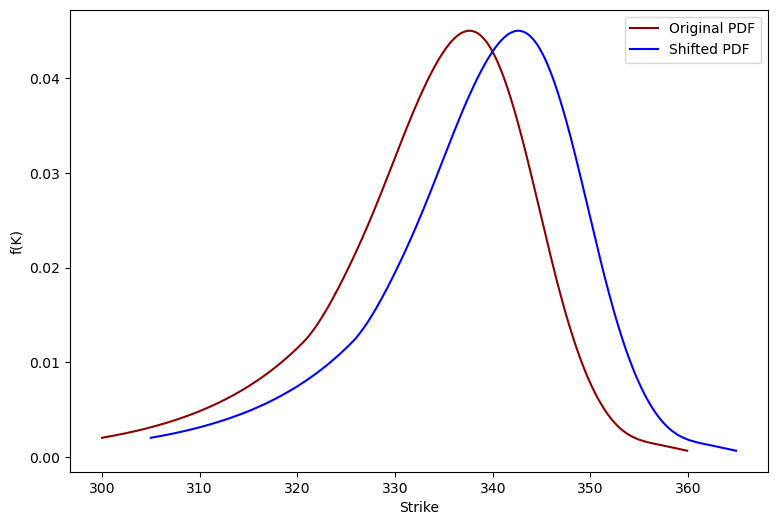

In [703]:
# Plot the original and shifted PDFs
plt.figure(figsize=(9, 6))

# Plot the original PDF (rn_pdf)
plt.plot(rn_pdf[:, 0], rn_pdf[:, 1], "darkred", label="Original PDF")

# Plot the shifted PDF
plt.plot(shifted_pdf[:, 0], shifted_pdf[:, 1], "blue", label="Shifted PDF")

plt.xlabel("Strike")
plt.ylabel("f(K)")
plt.legend(loc="best")
plt.show()


In [704]:
#COMPUTE THE GROWTH OPTIMIZER PAYOFF

# Interpolate the original PDF
rn_pdf_interp = interp1d(rn_pdf[:, 0], rn_pdf[:, 1], bounds_error=False, fill_value=0)

# Divide the shifted PDF by the interpolated original PDF
# Calculate the PDF values of the original PDF at the shifted strike prices
rn_pdf_values_at_shifted = rn_pdf_interp(shifted_pdf[:, 0])

# Handle division by zero by replacing zeros with a very small number
division = np.where(rn_pdf_values_at_shifted != 0, shifted_pdf[:, 1] / rn_pdf_values_at_shifted, 0)

# Create a function for the growth optimizer payoff
growth_optimizer_payoff_shift = interp1d(shifted_pdf[:, 0], division, kind='linear', fill_value='extrapolate')

C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_14692\3301309537.py:11: RuntimeWarning: divide by zero encountered in true_divide
  division = np.where(rn_pdf_values_at_shifted != 0, shifted_pdf[:, 1] / rn_pdf_values_at_shifted, 0)


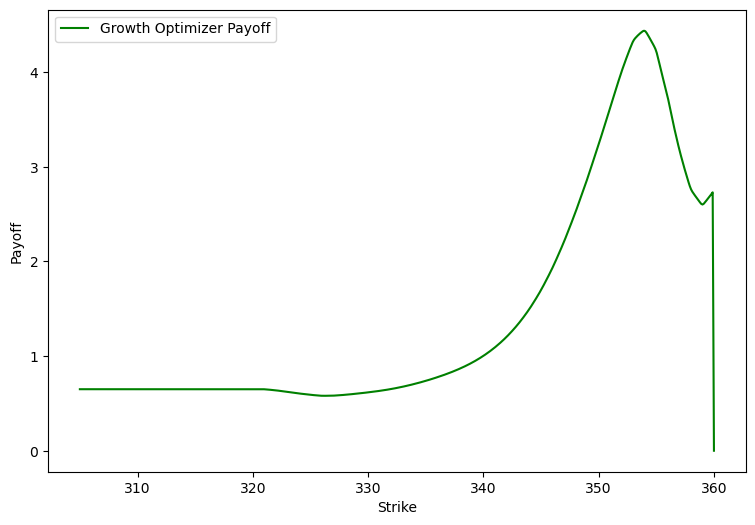

In [705]:
# Define the end of the range for plotting
end_range = min(360, np.max(shifted_pdf[:, 0]))

# Use a range of strike prices for plotting, stopping at 360 or the last available data point
strike_range = np.linspace(np.min(shifted_pdf[:, 0]), end_range, 500)

# Plot the growth optimizer payoff function
plt.figure(figsize=(9, 6))
plt.plot(strike_range, growth_optimizer_payoff_shift(strike_range), 'green', label='Growth Optimizer Payoff')

# Set labels and legend
plt.xlabel("Strike")
plt.ylabel("Payoff")
plt.legend(loc="best")

# Optionally save the figure
# plt.savefig("growth_optimizer_payoff.png", dpi=300)

plt.show()


In [706]:
# Define a range of x values for plotting
x_range = np.linspace(np.min(growth_optimizer_payoff_shift.x), np.max(growth_optimizer_payoff_shift.x), 100)

# Compute the ratio for each x value in the range
ratios = [ratio_function(x, growth_optimizer_payoff_shift) for x in x_range]
'''
# Plot the ratio
plt.figure(figsize=(9, 6))
plt.plot(x_range, ratios, 'green', label='Fraction of Function to its Derivative')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel("X")
plt.ylabel("Fraction")
plt.legend(loc="best")
plt.grid(True) 
# plt.savefig("function_to_derivative_fraction.png", dpi=300)
plt.show()
'''

'\n# Plot the ratio\nplt.figure(figsize=(9, 6))\nplt.plot(x_range, ratios, \'green\', label=\'Fraction of Function to its Derivative\')\nplt.axhline(y=1, color=\'gray\', linestyle=\'--\', linewidth=1)\nplt.xlabel("X")\nplt.ylabel("Fraction")\nplt.legend(loc="best")\nplt.grid(True) \n# plt.savefig("function_to_derivative_fraction.png", dpi=300)\nplt.show()\n'

In [707]:

# Define a range of x values for plotting
x_range = np.linspace(np.min(shifted_pdf[:, 0]), np.max(shifted_pdf[:, 0]), 100)

# Compute the ratio for each x value in the range
# Since growth_optimizer_payoff_shift is already a function, you don't need to wrap it with lambda
ratios = [ratio_function(x, growth_optimizer_payoff_shift) for x in x_range]
'''
# Plot the ratio
plt.figure(figsize=(9, 6))
plt.plot(x_range, ratios, 'green', label='Fraction of Function to its Derivative')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)

# Set the vertical limit of the plot
plt.ylim(-100, 100)

plt.xlabel("X")
plt.ylabel("Fraction")
plt.legend(loc="best")
plt.grid(True) 
plt.show()
'''

'\n# Plot the ratio\nplt.figure(figsize=(9, 6))\nplt.plot(x_range, ratios, \'green\', label=\'Fraction of Function to its Derivative\')\nplt.axhline(y=1, color=\'gray\', linestyle=\'--\', linewidth=1)\n\n# Set the vertical limit of the plot\nplt.ylim(-100, 100)\n\nplt.xlabel("X")\nplt.ylabel("Fraction")\nplt.legend(loc="best")\nplt.grid(True) \nplt.show()\n'

In [708]:
def maximum_of_function(f):
    def negative_function(x):
        return -f(x)

    # Find the maximum using minimize_scalar within the bounds of your data
    result = minimize_scalar(negative_function, bounds=(np.min(growth_optimizer_payoff_shift.x), np.max(growth_optimizer_payoff_shift.x)), method='bounded')

    # The maximum value and the point where it is achieved
    max_value = -result.fun
    max_point = result.x
    
    return max_value, max_point

C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_14692\3909978882.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  risk_aversion = [1/relative_risk_aversion(x, growth_optimizer_payoff_shift, rv_fr) for x in x_range]


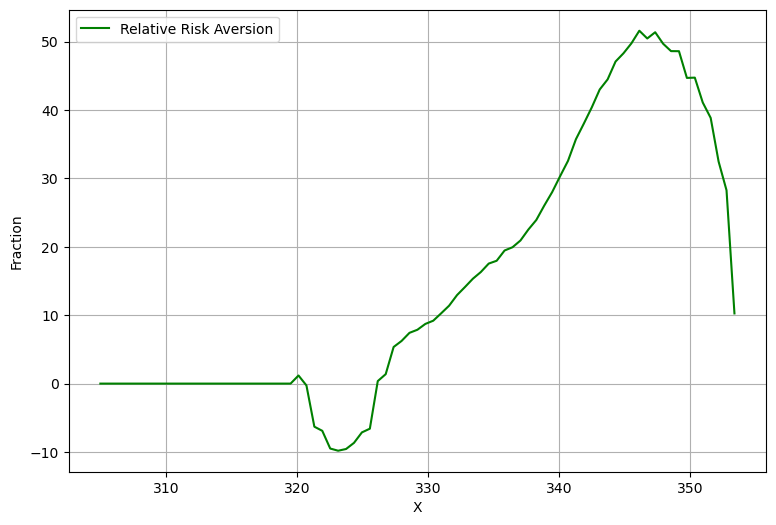

In [709]:
max_value, K = maximum_of_function(growth_optimizer_payoff_shift)

def rv_fr(x):
    return derivative_to_payoff_ratio_rc(x, K, K, 0.10*K, K)  

x_range = np.linspace(np.min(growth_optimizer_payoff_shift.x), np.max(growth_optimizer_payoff_shift.x), 100)
risk_aversion = [1/relative_risk_aversion(x, growth_optimizer_payoff_shift, rv_fr) for x in x_range]

plt.figure(figsize=(9, 6))
plt.plot(x_range, risk_aversion, 'green', label='Relative Risk Aversion')
plt.xlabel("X")
plt.ylabel("Fraction")
plt.legend(loc="best")
plt.grid(True)

plt.show()


## Change volatility

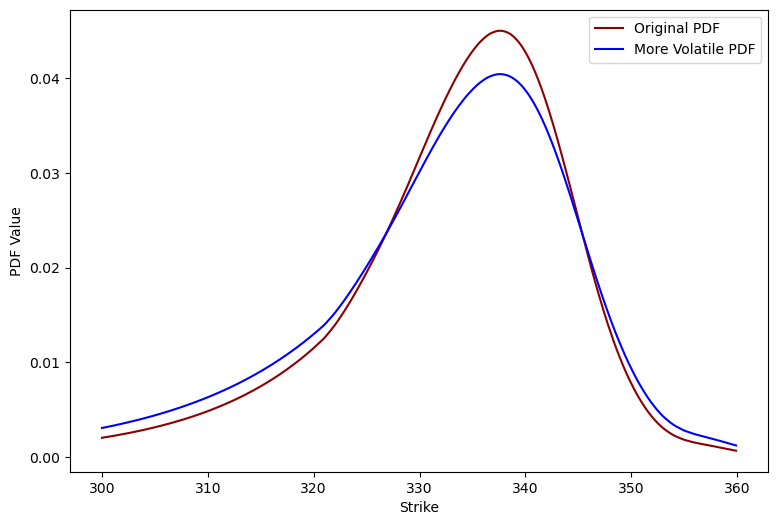

In [710]:
# Step 1: Increase volatility with a non-linear transformation
volatility_increase = 1.2  # Adjust this for more or less volatility
new_pdf_values = np.copy(rn_pdf[:, 1])
new_pdf_values = np.power(new_pdf_values, 1 / volatility_increase)

# Step 2: Normalize the new PDF
original_area = trapz(rn_pdf[:, 1], rn_pdf[:, 0])
new_area = trapz(new_pdf_values, rn_pdf[:, 0])
new_pdf_values *= (original_area / new_area)

# Step 3: Create the more volatile PDF
more_volatile_pdf = np.column_stack((rn_pdf[:, 0], new_pdf_values))

# Step 4: Plot both PDFs for comparison
plt.figure(figsize=(9,6))
plt.plot(rn_pdf[:, 0], rn_pdf[:, 1], 'darkred', label='Original PDF')
plt.plot(more_volatile_pdf[:, 0], more_volatile_pdf[:, 1], 'blue', label='More Volatile PDF')
plt.xlabel('Strike')
plt.ylabel('PDF Value')
plt.legend()
plt.show()

In [711]:
#COMPUTE THE GROWTH OPTIMIZER PAYOFF

# Interpolate the original PDF
original_pdf_interp = interp1d(rn_pdf[:, 0], rn_pdf[:, 1], bounds_error=False, fill_value=0)

# Divide the more volatile PDF by the interpolated original PDF
# Calculate the PDF values of the original PDF at the more volatile PDF's strike prices
original_pdf_values_at_more_volatile = original_pdf_interp(more_volatile_pdf[:, 0])

# Perform the division
division = more_volatile_pdf[:, 1] / np.where(original_pdf_values_at_more_volatile != 0, 
                                              original_pdf_values_at_more_volatile, 1)

# Create a function for the growth optimizer payoff
growth_optimizer_payoff_vol = interp1d(more_volatile_pdf[:, 0], division, kind='linear', fill_value='extrapolate')



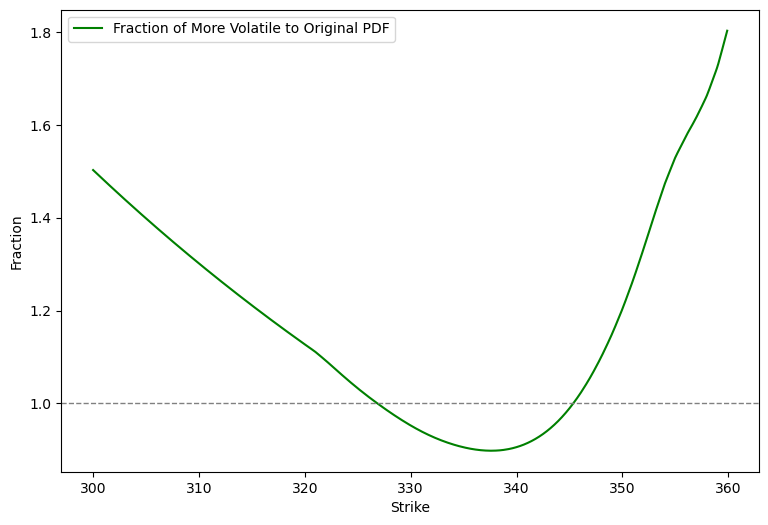

In [712]:
# Plot the function
plt.figure(figsize=(9,6))

# Use a range of strike prices for plotting
strike_range = np.linspace(np.min(more_volatile_pdf[:, 0]), np.max(more_volatile_pdf[:, 0]), 500)
plt.plot(strike_range, growth_optimizer_payoff_vol(strike_range), 'green', label='Fraction of More Volatile to Original PDF')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Strike")
plt.ylabel("Fraction")
plt.legend(loc="best")
# plt.savefig("more_volatile_to_original_fraction.png", dpi=300)
plt.show()

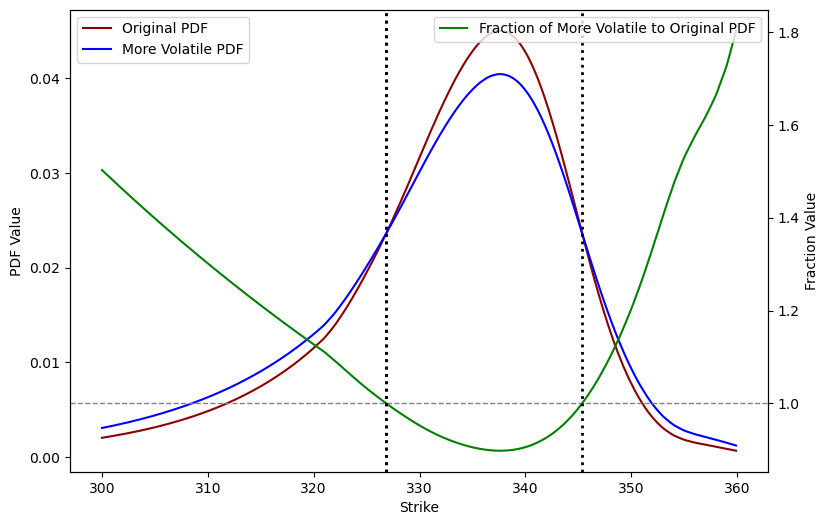

In [713]:
#PLOT TOGETHER WITH SCALED PDFs

plt.figure(figsize=(9,6))

# Plot the Original PDF and More Volatile PDF
plt.plot(rn_pdf[:, 0], rn_pdf[:, 1], 'darkred', label='Original PDF')
plt.plot(more_volatile_pdf[:, 0], more_volatile_pdf[:, 1], 'blue', label='More Volatile PDF')

plt.xlabel("Strike")
plt.ylabel("PDF Value")
plt.legend(loc="upper left")

# Create secondary y-axis for the fraction
ax2 = plt.gca().twinx()

# Calculate and Plot the Fraction of More Volatile to Original PDF on the secondary y-axis
strike_range = np.linspace(np.min(more_volatile_pdf[:, 0]), np.max(more_volatile_pdf[:, 0]), 1000)
fractions = growth_optimizer_payoff_vol(strike_range)
ax2.plot(strike_range, fractions, 'green', label='Fraction of More Volatile to Original PDF')

# Add a horizontal line at y=1 for reference on the secondary y-axis
ax2.axhline(y=1, color='gray', linestyle='--', linewidth=1)
ax2.set_ylabel("Fraction Value")
ax2.legend(loc="upper right")

# Add more visible vertical dotted lines where the fraction is approximately 1
tolerance = 0.001  # Very small tolerance for precision
equal_points = strike_range[np.abs(fractions - 1) < tolerance]
for x in equal_points:
    plt.axvline(x=x, color='black', linestyle=':', linewidth=2)

plt.show()


### Less skewed vol surface

In [770]:
# Your original data arrays.
strikes = calls_clean.strike
iv = calls_clean.iv

# Define the at-the-money (ATM) strike
atm_strike = 332# your ATM strike value here

# Find the index of the ATM strike
atm_index = np.where(strikes == atm_strike)[0][0]

# Define the smoothing factor for IV adjustments; you can tweak this factor.
smoothing_factor = -0.005  # Smaller values mean less skew

# Adjust IVs smoothly around the ATM strike
# Here we decrease the IV before the ATM and increase it after the ATM.
adjusted_iv = np.copy(iv)
for i in range(len(strikes)):
    if i < atm_index:
        adjusted_iv[i] -= (atm_index - i) * smoothing_factor * (iv.iloc[atm_index] - iv.iloc[i])
    elif i > atm_index:
        adjusted_iv[i] += (i - atm_index) * smoothing_factor * (iv.iloc[i] - iv.iloc[atm_index])

# Make sure the adjusted IV at ATM is the same as the original
adjusted_iv[atm_index] = iv.iloc[atm_index]

# Create the adjusted volatility surface
adjusted_vol_surface = scipy.interpolate.interp1d(strikes, adjusted_iv, kind="cubic", fill_value="extrapolate")

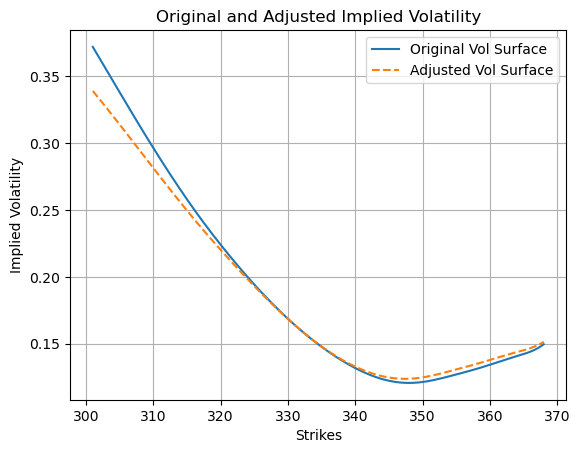

In [771]:
x_range = np.linspace(strikes.min(), 368, 1000)

# Plot the original and adjusted volatility surfaces
plt.plot(x_range, vol_surface(x_range), label='Original Vol Surface')
plt.plot(x_range, adjusted_vol_surface(x_range), label='Adjusted Vol Surface', linestyle='--')
plt.title('Original and Adjusted Implied Volatility')
plt.xlabel('Strikes')
plt.ylabel('Implied Volatility')
plt.legend()
plt.grid(True)
plt.show()

In [772]:
C_interp_adjusted = call_value(S, x_new, adjusted_vol_surface(x_new), t)

first_deriv2 = np.gradient(C_interp_adjusted, x_new)
second_deriv2 = np.gradient(first_deriv2, x_new)

def pdf2(Krange, S, t=0, r=0):
    # x is a range of strikes
    Crange = call_value(S, Krange, adjusted_vol_surface(Krange), t, r)
    first_deriv2 = np.gradient(Crange, x_new, edge_order=0)
    second_deriv2 = np.gradient(first_deriv2, x_new, edge_order=0)
    return np.exp(r * t) * second_deriv2

In [773]:
data2 = np.vstack([x_new, pdf2(x_new, S, t)]).T
data2 = data2[(data2[:, 0] < 360) & (data2[:, 0] > 320)]
k, curve_pdf2 = np.hsplit(data2, 2)

In [774]:
# Flatten the arrays if they are 2D
k_flat = k.flatten()
curve_pdf_flat2 = curve_pdf2.flatten()

# Create a 2D array for the original PDF
original_pdf2 = np.column_stack((k_flat, curve_pdf_flat2))

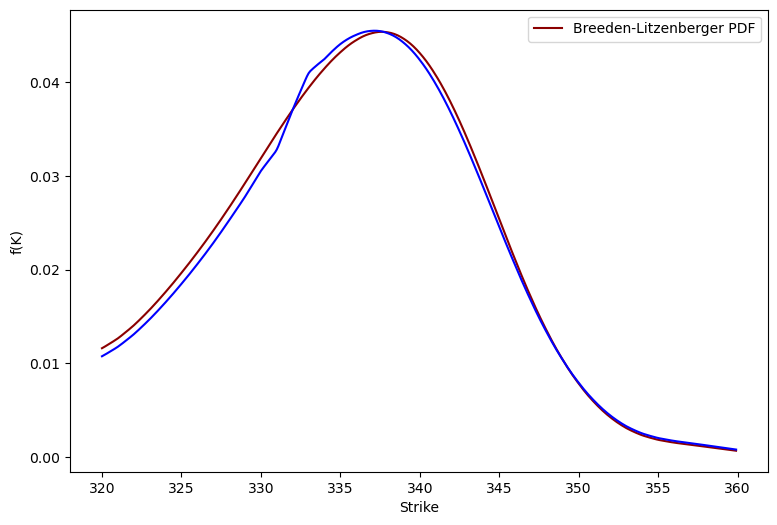

In [775]:
plt.figure(figsize=(9,6))
plt.plot(original_pdf[:, 0], original_pdf[:, 1], "darkred")

# plt.savefig("breeden_litzenberger_pdf.png", dpi=300)


plt.plot(original_pdf2[:, 0], original_pdf2[:, 1], "blue")
plt.xlabel("Strike")
plt.ylabel("f(K)")
plt.legend(["Breeden-Litzenberger PDF"], loc="best")
plt.show()

In [776]:
skewed_pdf = new_pdf

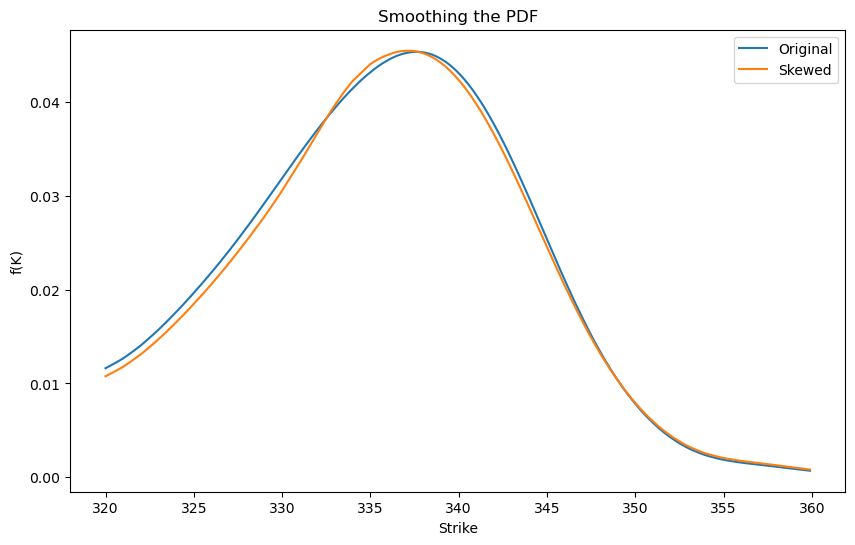

In [781]:
# Define the range to remove [331, 334]
mask = (original_pdf2[:, 0] < 330) | (original_pdf2[:, 0] > 335)
filtered_x = original_pdf2[:, 0][mask]
filtered_y = original_pdf2[:, 1][mask]

# Interpolate to fill in the removed part
interpolator = interp1d(filtered_x, filtered_y, kind='cubic', fill_value="extrapolate")

# Points to interpolate
interpolated_x = np.linspace(331, 334, num=50)  # You can adjust the number of points
interpolated_y = interpolator(interpolated_x)

# Combine the parts to form the new smoothed array
smoothed_x = np.concatenate((filtered_x[filtered_x <= 331], interpolated_x, filtered_x[filtered_x > 334]))
smoothed_y = np.concatenate((filtered_y[filtered_x <= 331], interpolated_y, filtered_y[filtered_x > 334]))
skewed_pdf = np.column_stack((smoothed_x, smoothed_y))

plt.figure(figsize=(10, 6))
plt.plot(original_pdf[:, 0], original_pdf[:, 1], label='Original')
plt.plot(skewed_pdf[:, 0], skewed_pdf[:, 1], label='Skewed')
plt.xlabel('Strike')
plt.ylabel('f(K)')
plt.title('Smoothing the PDF')
plt.legend()
plt.show()


In [780]:
'''
# Separate the original data into x and y components for clarity
x_original = original_pdf2[:, 0]
y_original = original_pdf2[:, 1]

# Define the exponential decay function
def exp_decay(x, a, b, c):
    return a * np.exp(-b * (x - c))

# Use the leftmost points of the original data to fit the exponential decay
left_points_x = x_original[:10]  # Use more points if necessary for a better fit
left_points_y = y_original[:10]
params, _ = curve_fit(exp_decay, left_points_x, left_points_y, p0=(1, 1, x_original[0]))

# Define the range for extrapolation
x_min_extrapolate = 300  # Adjust this as needed

# Generate new x values for extrapolation
x_extrapolate = np.linspace(x_min_extrapolate, x_original[0], num=100, endpoint=False)

# Generate new y values using the fitted exponential decay
y_extrapolate = exp_decay(x_extrapolate, *params)

# Combine the extrapolated points with the original data
extrapolated_pdf = np.column_stack((x_extrapolate, y_extrapolate))
new_pdf = np.vstack((extrapolated_pdf, original_pdf2))

# Normalize the curve so the total area is 1
x_values = new_pdf[:, 0]
y_values = new_pdf[:, 1]
area = simps(y_values, x_values)
y_values_normalized = y_values / area

# Replace the y-values in new_pdf with normalized values
new_pdf[:, 1] = y_values_normalized
skewed_pdf = new_pdf

# Plot the original and the new PDF
plt.figure(figsize=(10, 6))
plt.plot(rn_pdf[:, 0], rn_pdf[:, 1], label='Original Data')
plt.plot(skewed_pdf[:, 0], skewed_pdf[:, 1], label='Extended and Normalized PDF')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('PDF Extrapolation and Normalization')
plt.legend()
plt.grid(True)
plt.show()
'''

"\n# Separate the original data into x and y components for clarity\nx_original = original_pdf2[:, 0]\ny_original = original_pdf2[:, 1]\n\n# Define the exponential decay function\ndef exp_decay(x, a, b, c):\n    return a * np.exp(-b * (x - c))\n\n# Use the leftmost points of the original data to fit the exponential decay\nleft_points_x = x_original[:10]  # Use more points if necessary for a better fit\nleft_points_y = y_original[:10]\nparams, _ = curve_fit(exp_decay, left_points_x, left_points_y, p0=(1, 1, x_original[0]))\n\n# Define the range for extrapolation\nx_min_extrapolate = 300  # Adjust this as needed\n\n# Generate new x values for extrapolation\nx_extrapolate = np.linspace(x_min_extrapolate, x_original[0], num=100, endpoint=False)\n\n# Generate new y values using the fitted exponential decay\ny_extrapolate = exp_decay(x_extrapolate, *params)\n\n# Combine the extrapolated points with the original data\nextrapolated_pdf = np.column_stack((x_extrapolate, y_extrapolate))\nnew_pdf

In [841]:
#COMPUTE THE GROWTH OPTIMIZER PAYOFF

# Interpolate the original PDF
original_pdf_interp = interp1d(rn_pdf[:, 0], rn_pdf[:, 1], bounds_error=False, fill_value=0)

# Divide the more volatile PDF by the interpolated original PDF
# Calculate the PDF values of the original PDF at the more volatile PDF's strike prices
original_pdf_values_at_less_skewed = original_pdf_interp(skewed_pdf[:, 0])

# Perform the division
division = skewed_pdf[:, 1] / np.where(original_pdf_values_at_less_skewed != 0, 
                                              original_pdf_values_at_less_skewed, 1)

# Create a function for the growth optimizer payoff
growth_optimizer_payoff_less_skewed = interp1d(skewed_pdf[:, 0], division, kind='linear', fill_value='extrapolate')

In [844]:
mask = (skewed_pdf[:, 0] < 322) | (skewed_pdf[:, 0] > 336)
x_smooth = skewed_pdf[:, 0][mask]
division_smooth = division[mask]

# Interpolate to create a smoother part
smoother_interpolator = interp1d(x_smooth, division_smooth, kind='cubic', fill_value='extrapolate')

# Replace the rough part with the smoother part
x_to_replace = skewed_pdf[:, 0][(skewed_pdf[:, 0] >= 322) & (skewed_pdf[:, 0] <= 336)]
smoothed_division = smoother_interpolator(x_to_replace)

# Combine the smooth parts with the new smoothed section
combined_x = np.concatenate((x_smooth[x_smooth < 328], x_to_replace, x_smooth[x_smooth > 336]))
combined_division = np.concatenate((division_smooth[x_smooth < 328], smoothed_division, division_smooth[x_smooth > 336]))

# Create a new 2D array from the combined data
growth_optimizer_payoff_skewed = np.column_stack((combined_x, combined_division))
growth_optimizer_payoff_skew = interp1d(growth_optimizer_payoff_skewed[:, 0], division, kind='linear', fill_value='extrapolate')

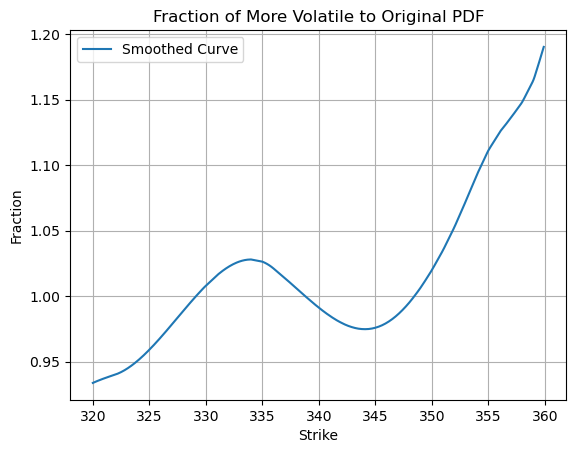

In [845]:
plt.plot(growth_optimizer_payoff_skewed[:, 0], growth_optimizer_payoff_skewed[:, 1], label='Smoothed Curve')
plt.xlabel('Strike')
plt.ylabel('Fraction')
plt.title('Fraction of More Volatile to Original PDF')
plt.legend()
plt.grid(True)
plt.show()

In [817]:
def new_piecewise_function(x):
    a1 = 0.07/9
    b1 = 1-329*a1
    c = 329*a1+b1
    a2 = 0.19/12
    b2 = 1-348*a2
    
    if x < 329:
        return a1*x + b1
    elif 329 <= x < 348:
        return c
    else:
        return a2*x+ b2

In [829]:
def new_piecewise_function2(x):
    if x < 339:
        return 1.025
    elif 339 <= x < 340:
        return 1.025
    else:
        return 0.98

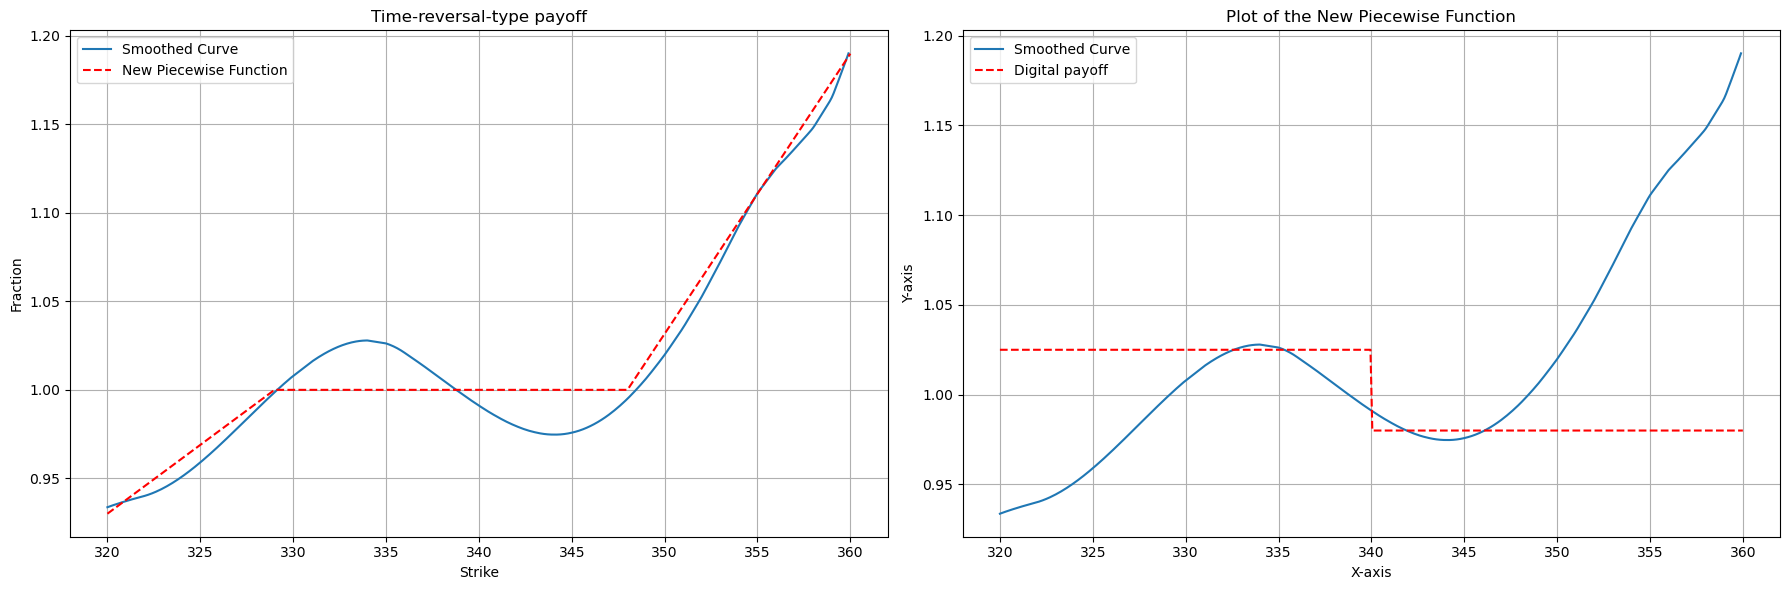

In [846]:
x_values = np.linspace(320, 360, 400)
vectorized_new_function = np.vectorize(new_piecewise_function)
y_values_new = vectorized_new_function(x_values)

vectorized_new_function2 = np.vectorize(new_piecewise_function2)
y_values_new2 = vectorized_new_function2(x_values)

plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(growth_optimizer_payoff_skewed[:, 0], growth_optimizer_payoff_skewed[:, 1], label='Smoothed Curve')
plt.title('Fraction of More Volatile to Original PDF')

plt.plot(x_values, y_values_new, linestyle='--', label='New Piecewise Function', color='red')
plt.xlabel('Strike')
plt.ylabel('Fraction')
plt.title('Time-reversal-type payoff')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(growth_optimizer_payoff_skewed[:, 0], growth_optimizer_payoff_skewed[:, 1], label='Smoothed Curve')
plt.title('Fraction of More Volatile to Original PDF')

plt.plot(x_values, y_values_new2, linestyle='--', label='Digital payoff', color='red')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Plot of the New Piecewise Function')
plt.legend()
plt.grid(True)

plt.tight_layout()  
plt.show()

### Reverse Convertible

In [131]:
def ratio_function(x, growth_optimizer_payoff):
    # Function to compute the derivative
    def derivative_of_growth_optimizer(x):
        return derivative(growth_optimizer_payoff, x, dx=1e-6)
    
    # Function to compute the ratio of the original function to its derivative
    original_value = growth_optimizer_payoff(x)
    derivative_value = derivative_of_growth_optimizer(x)
    return original_value / derivative_value if derivative_value != 0 else np.inf

In [132]:
def relative_risk_aversion(x, growth_optimizer_payoff, general_payoff_ratio):
    return ratio_function(x, growth_optimizer_payoff) * general_payoff_ratio(x)

C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_14692\3660744459.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  risk_aversion_rc = [1/relative_risk_aversion(x, growth_optimizer_payoff_vol, rc) for x in x_range]
C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_14692\3660744459.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  risk_aversion_brc = [1/relative_risk_aversion(x, growth_optimizer_payoff_vol, brc) for x in x_range]


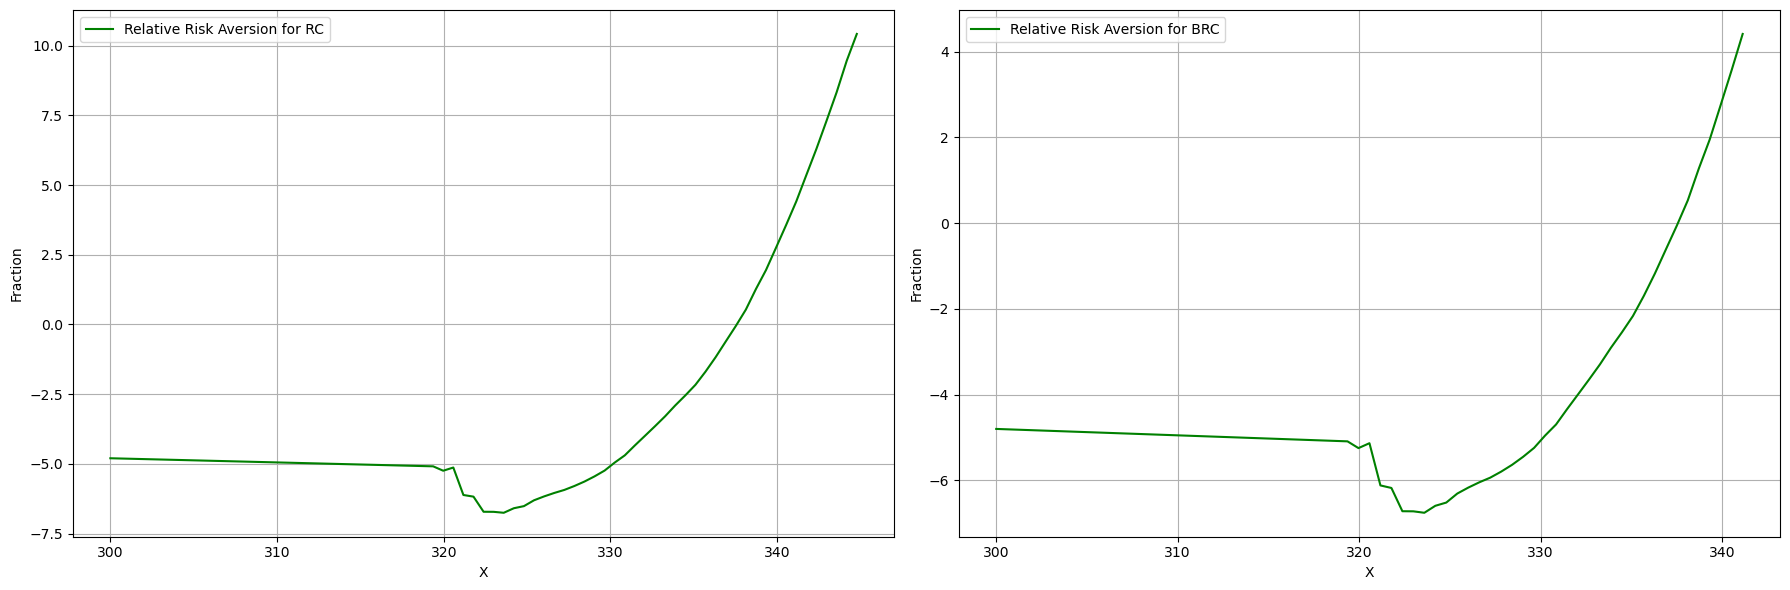

In [833]:
K = 345

def rc(x):
    return derivative_to_payoff_ratio_rc(x, K, K, 0.10*K, K) 

def brc(x):
    return derivative_to_payoff_ratio_brc(x, K, K, 0.10*K, K, 0.99*K)

x_range = np.linspace(np.min(growth_optimizer_payoff_vol.x), np.max(growth_optimizer_payoff_vol.x), 100)
risk_aversion_rc = [1/relative_risk_aversion(x, growth_optimizer_payoff_vol, rc) for x in x_range]
risk_aversion_brc = [1/relative_risk_aversion(x, growth_optimizer_payoff_vol, brc) for x in x_range]

# Create a figure with two subplots
plt.figure(figsize=(18, 6))  # Set the figure size to be wide enough for two subplots

# Plot for the existing function on the left
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(x_range, risk_aversion_rc, 'green', label='Relative Risk Aversion for RC')
plt.xlabel("X")
plt.ylabel("Fraction")
plt.legend(loc="best")
plt.grid(True)

# Template for another graph on the right
plt.subplot(1, 2, 2) 
plt.plot(x_range, risk_aversion_brc, 'green', label='Relative Risk Aversion for BRC')
plt.xlabel("X")
plt.ylabel("Fraction")
plt.legend(loc="best")
plt.grid(True)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()  # Show the combined figure with both subplots


## Belief of a RC investor

An investor who buys a rreverse convertible with strike ATM expects low volatility and that the price of the underlying will make a slight rise. So his belief on the pdf of the underlying could be the following.

In [134]:
def compute_expectation(pdf_array):
    """
    Compute the expectation of a given PDF represented as a 2D array using a numerical method.

    Parameters:
    pdf_array (numpy.ndarray): A 2D array where the first column contains the x-values,
                               and the second column contains the corresponding PDF values.

    Returns:
    float: The expectation value of the PDF.
    """
    x_values = pdf_array[:, 0]
    pdf_values = pdf_array[:, 1]

    # Compute x * f(x)
    x_times_pdf = x_values * pdf_values

    # Compute the integral of x * f(x)
    expectation = trapz(x_times_pdf, x_values)
    return expectation

# Compute the expectation
expectation_value = compute_expectation(rn_pdf)
print("Expectation:", expectation_value)


Expectation: 333.4983464535587


So the market (risk neutral pdf) expects that the price of the underline will slightly rise from 332 to 333.5. Now lets assume that the investor believes that the price will rise to 336.2 (mean) and the volatility will be small. Then his belief might be.

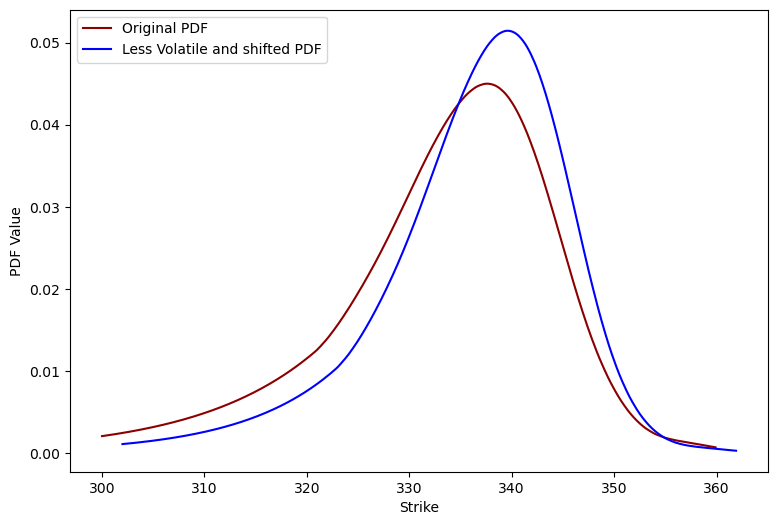

In [135]:
# Step 1: Decrese volatility with a non-linear transformation
volatility_increase = 0.8  # Adjust this for more or less volatility
new_pdf_values = np.copy(rn_pdf[:, 1])
new_pdf_values = np.power(new_pdf_values, 1 / volatility_increase)

# Step 2: Normalize the new PDF
original_area = trapz(rn_pdf[:, 1], rn_pdf[:, 0])
new_area = trapz(new_pdf_values, rn_pdf[:, 0])
new_pdf_values *= (original_area / new_area)

# Step 3: Create the less volatile and shifted PDF
shift = 2
rc_pdf = np.column_stack((rn_pdf[:, 0] + shift, new_pdf_values))

# Step 4: Plot both PDFs for comparison
plt.figure(figsize=(9,6))
plt.plot(rn_pdf[:, 0], rn_pdf[:, 1], 'darkred', label='Original PDF')
plt.plot(rc_pdf[:, 0], rc_pdf[:, 1], 'blue', label='Less Volatile and shifted PDF')
plt.xlabel('Strike')
plt.ylabel('PDF Value')
plt.legend()
plt.show()

In [136]:
#COMPUTE THE GROWTH OPTIMIZER PAYOFF

# Interpolate the original PDF
original_pdf_interp = interp1d(rn_pdf[:, 0], rn_pdf[:, 1], bounds_error=False, fill_value=0)

# Divide the more volatile PDF by the interpolated original PDF
# Calculate the PDF values of the original PDF at the more volatile PDF's strike prices
original_pdf_values_at_rc_pdf = original_pdf_interp(rc_pdf[:, 0])

# Perform the division
division = rc_pdf[:, 1] / np.where(original_pdf_values_at_rc_pdf != 0, 
                                              original_pdf_values_at_rc_pdf, 1)

# Create a function for the growth optimizer payoff
growth_optimizer_payoff_rc = interp1d(rc_pdf[:, 0], division, kind='linear', fill_value='extrapolate')

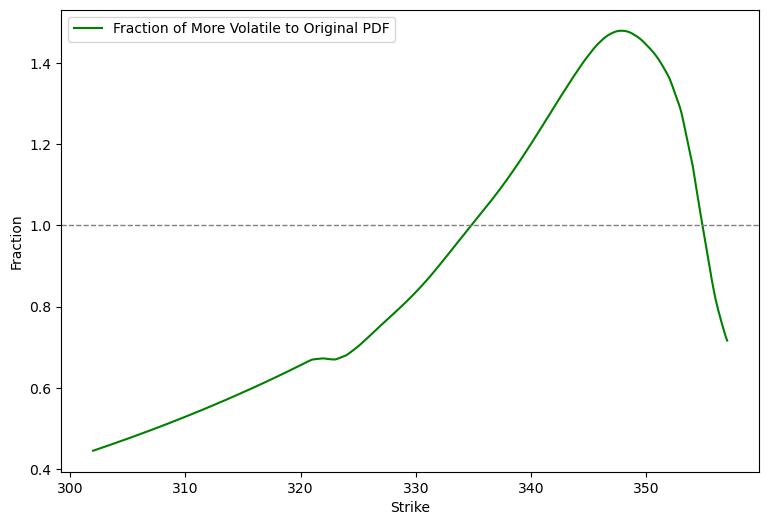

In [137]:
# Plot the function
plt.figure(figsize=(9,6))

# Use a range of strike prices for plotting
strike_range = np.linspace(np.min(rc_pdf[:, 0]), 357, 500)
plt.plot(strike_range, growth_optimizer_payoff_rc(strike_range), 'green', label='Fraction of More Volatile to Original PDF')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Strike")
plt.ylabel("Fraction")
plt.legend(loc="best")
# plt.savefig("more_volatile_to_original_fraction.png", dpi=300)
plt.show()

C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_14692\2662784032.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  risk_aversion = [1/relative_risk_aversion(x, growth_optimizer_payoff_rc, rv_fr) for x in x_range]


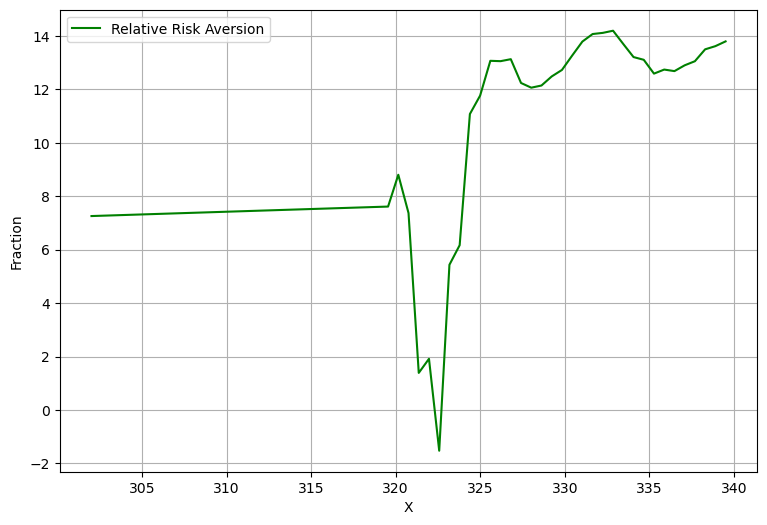

In [835]:
K = 340

def rv_fr(x):
    return derivative_to_payoff_ratio_rc(x, K, K, 0.10*K, K)  

x_range = np.linspace(np.min(growth_optimizer_payoff_rc.x), np.max(growth_optimizer_payoff_rc.x), 100)
risk_aversion = [1/relative_risk_aversion(x, growth_optimizer_payoff_rc, rv_fr) for x in x_range]

plt.figure(figsize=(9, 6))
plt.plot(x_range, risk_aversion, 'green', label='Relative Risk Aversion')
plt.xlabel("X")
plt.ylabel("Fraction")
plt.legend(loc="best")
plt.grid(True)

plt.show()


# Derivative Structuring

## Shift

In [993]:
def custom_risk_aversion1(x):
    c1 = 100
    c2 = 10
    c3 = 20
    a1 = (c2-c1)/4
    b1 = c2 - 332*a1
    a2 = (c3-c2)/4
    b2 = c3 - 352*a2
    
    if x < 328:
        return c1
    elif 328 <= x < 332:
        return a1*x+b1
    elif 332 <= x < 348:
        return c2
    elif 348 <= x < 352:
        return a2*x+b2
    else:
        return c3
    
def custom_risk_aversion2(x):
    return custom_risk_aversion1(x) + 5

def custom_risk_aversion3(x):
    return custom_risk_aversion1(x) - 5

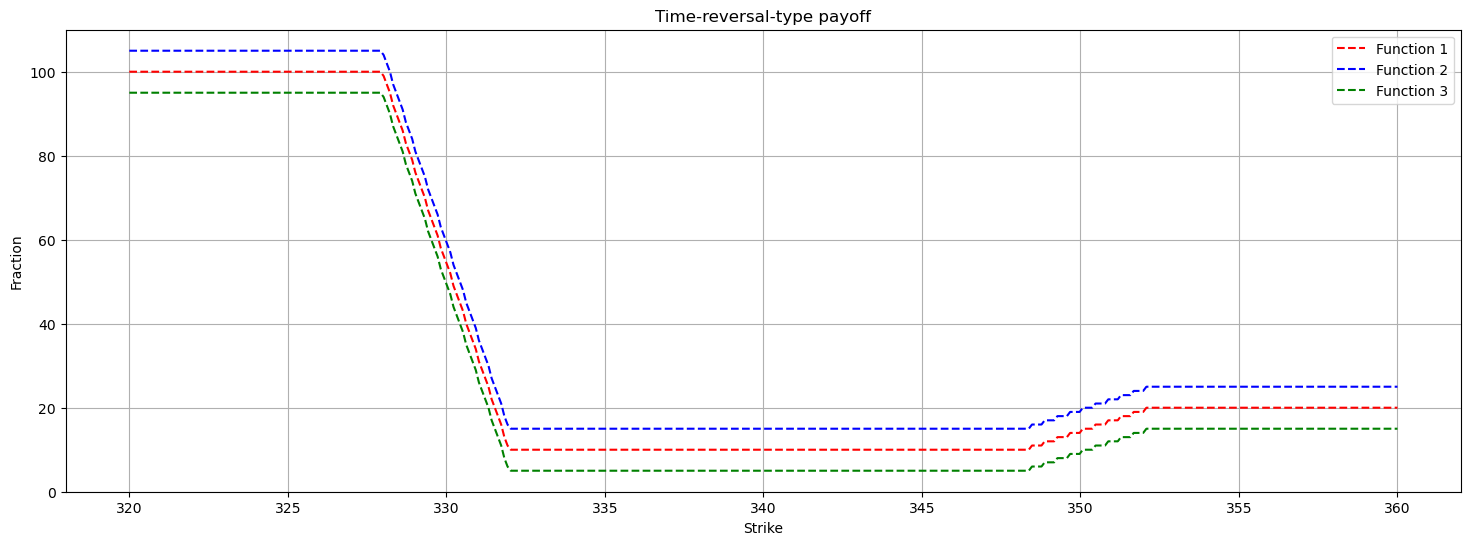

In [994]:
x_values = np.linspace(320, 360, 400)
vectorized_new_function3 = np.vectorize(custom_risk_aversion1)
y_values_new3 = vectorized_new_function3(x_values)
vectorized_new_function4 = np.vectorize(custom_risk_aversion2)
y_values_new4 = vectorized_new_function4(x_values)  # Corrected to use function4
vectorized_new_function5 = np.vectorize(custom_risk_aversion3)
y_values_new5 = vectorized_new_function5(x_values)  # Corrected to use function5

plt.figure(figsize=(18, 6))
plt.plot(x_values, y_values_new3, linestyle='--', label='Function 1', color='red')
plt.plot(x_values, y_values_new4, linestyle='--', label='Function 2', color='blue')
plt.plot(x_values, y_values_new5, linestyle='--', label='Function 3', color='green')

plt.xlabel('Strike')
plt.ylabel('Fraction')
plt.title('Time-reversal-type payoff')
plt.legend()
plt.grid(True)
plt.show()


In [995]:

def c_shift(x):
    f_interpolated = growth_optimizer_payoff_shift
    f_x = f_interpolated(x)
    f_prime_x = derivative(f_interpolated, x, dx=1e-6, n=1)

    return f_prime_x / f_x

def c_vol(x):
    f_interpolated = growth_optimizer_payoff_vol
    f_x = f_interpolated(x)
    f_prime_x = derivative(f_interpolated, x, dx=1e-6, n=1)

    return f_prime_x / f_x

def c_rc(x):
    f_interpolated = growth_optimizer_payoff_rc
    f_x = f_interpolated(x)
    f_prime_x = derivative(f_interpolated, x, dx=1e-6, n=1)

    return f_prime_x / f_x

def c_skew(x):
    f_interpolated = interp1d(growth_optimizer_payoff_skewed[:, 0], growth_optimizer_payoff_skewed[:, 1], kind='cubic', fill_value="extrapolate")
    f_x = f_interpolated(x)
    f_prime_x = derivative(f_interpolated, x, dx=1e-6, n=1)

    return f_prime_x / f_x

def R1(F):
    return custom_risk_aversion1(x)

def R2(F):
    return custom_risk_aversion2(x)

def R3(F):
    return custom_risk_aversion3(x)

def ode1_shift(x, F):
    return c_shift(x) * F / R1(F)

def ode2_shift(x, F):
    return c_shift(x) * F / R2(F)

def ode3_shift(x, F):
    return c_shift(x) * F / R3(F)

def ode1_vol(x, F):
    return c_vol(x) * F / R1(F)

def ode2_vol(x, F):
    return c_vol(x) * F / R2(F)

def ode3_vol(x, F):
    return c_vol(x) * F / R3(F)

def ode1_rc(x, F):
    return c_rc(x) * F / R1(F)

def ode2_rc(x, F):
    return c_rc(x) * F / R2(F)

def ode3_rc(x, F):
    return c_rc(x) * F / R3(F)

def ode1_skew(x, F):
    return c_skew(x) * F / R1(F)

def ode2_skew(x, F):
    return c_skew(x) * F / R2(F)

def ode3_skew(x, F):
    return c_skew(x) * F / R3(F)

# Initial condition (x0, F0)
x0 = 320 # Starting value of x
F0 = 0.95  # Initial value of F(x) at x0

x_end = 360  # End value of x
x_values1 = np.linspace(300, x_end, 100)  # Range of x values
x_values2 = np.linspace(320, x_end, 100)  # Range of x values

# Solve the ODE
solution1_shift = solve_ivp(ode1_shift, [300, x_end], [1], t_eval=x_values1)
solution2_shift = solve_ivp(ode2_shift, [300, x_end], [1.01], t_eval=x_values1)
solution3_shift = solve_ivp(ode3_shift, [300, x_end], [0.99], t_eval=x_values1)
solution1_vol = solve_ivp(ode1_vol, [300, x_end], [1], t_eval=x_values1)
solution2_vol = solve_ivp(ode2_vol, [300, x_end], [1.01], t_eval=x_values1)
solution3_vol = solve_ivp(ode3_vol, [300, x_end], [0.99], t_eval=x_values1)
solution1_rc = solve_ivp(ode1_rc, [300, x_end], [1], t_eval=x_values1)
solution2_rc = solve_ivp(ode2_rc, [300, x_end], [1.05], t_eval=x_values1)
solution3_rc = solve_ivp(ode3_rc, [300, x_end], [0.95], t_eval=x_values1)
solution1_skew = solve_ivp(ode1_skew, [320, x_end], [1], t_eval=x_values2)
solution2_skew = solve_ivp(ode2_skew, [320, x_end], [1.05], t_eval=x_values2)
solution3_skew = solve_ivp(ode3_skew, [320, x_end], [0.95], t_eval=x_values2)


In [996]:
# Define a new function that applies the power transformation
def general_payoff_power_shift(x, gamma):
    return growth_optimizer_payoff_shift(x) ** (1 / gamma)

def general_payoff_power_vol(x, gamma):
    return growth_optimizer_payoff_vol(x) ** (1 / gamma)

def general_payoff_power_rc(x, gamma):
    return growth_optimizer_payoff_rc(x) ** (1 / gamma)

def general_payoff_power_skew(x, gamma):
    return growth_optimizer_payoff_skew(x) ** (1 / gamma)

def general_payoff_exponential_shift(x, gamma):
    return np.log(growth_optimizer_payoff_shift(x))/gamma

def general_payoff_exponential_vol(x, gamma):
    return np.log(growth_optimizer_payoff_vol(x))/gamma

def general_payoff_exponential_rc(x, gamma):
    return np.log(growth_optimizer_payoff_rc(x))/gamma

def general_payoff_exponential_skew(x, gamma):
    return np.log(growth_optimizer_payoff_skew(x))/gamma

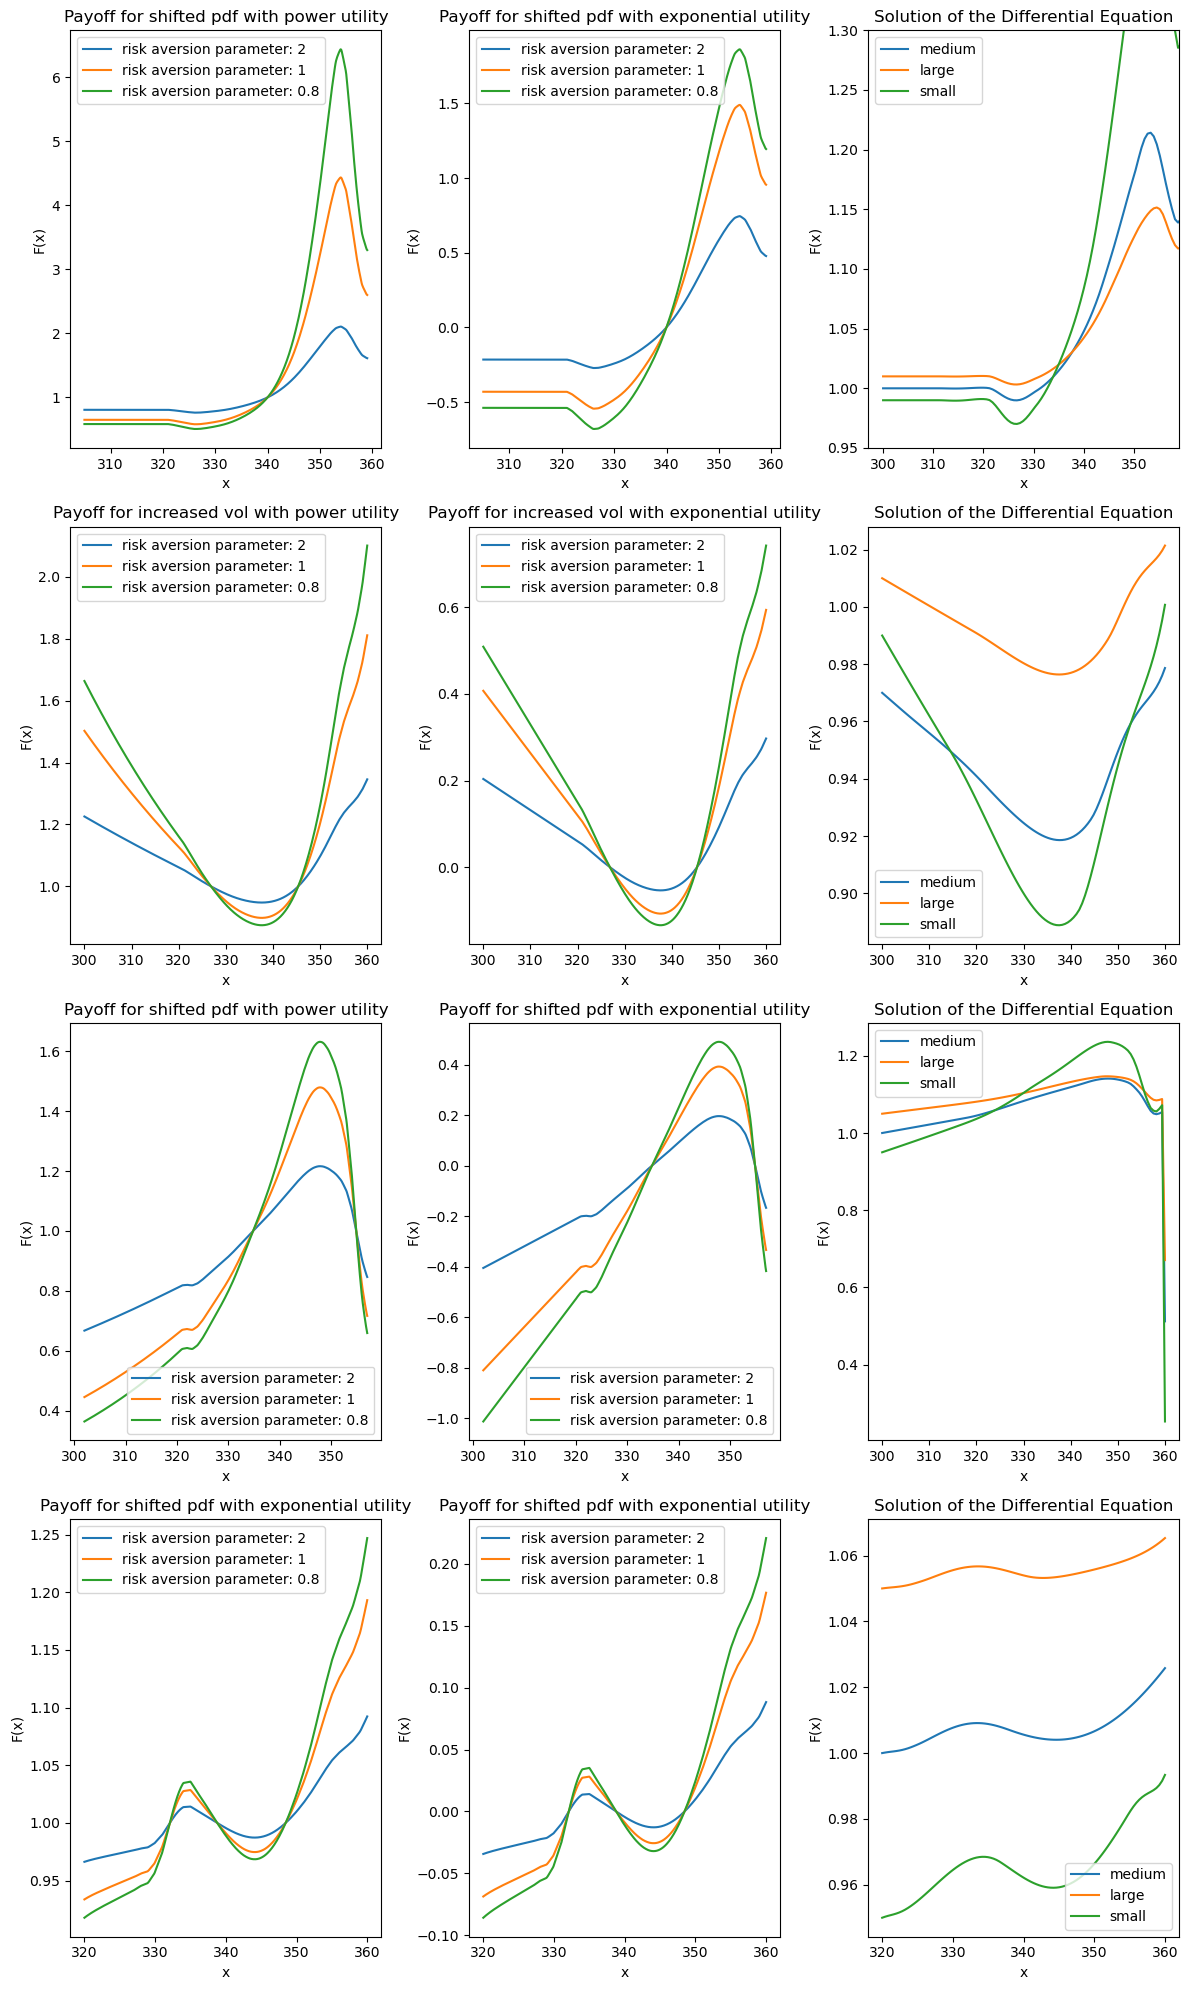

In [997]:
strike_range_shift = np.linspace(np.min(shifted_pdf[:, 0]), 359, 500)
strike_range_vol = np.linspace(np.min(more_volatile_pdf[:, 0]), end_range, 500)
strike_range_rc = np.linspace(np.min(rc_pdf[:, 0]), 357, 500)
strike_range_skew = np.linspace(np.min(skewed_pdf[:, 0]), end_range, 500)

plt.figure(figsize=(12, 20)) 

plt.subplot(4, 3, 1) 
plt.plot(strike_range_shift, general_payoff_power_shift(strike_range_shift, 2), label='risk aversion parameter: 2')
plt.plot(strike_range_shift, general_payoff_power_shift(strike_range_shift, 1), label='risk aversion parameter: 1')
plt.plot(strike_range_shift, general_payoff_power_shift(strike_range_shift, 0.8), label='risk aversion parameter: 0.8')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('Payoff for shifted pdf with power utility')
plt.legend()

plt.subplot(4, 3, 2) 
plt.plot(strike_range_shift, general_payoff_exponential_shift(strike_range_shift, 2), label='risk aversion parameter: 2')
plt.plot(strike_range_shift, general_payoff_exponential_shift(strike_range_shift, 1), label='risk aversion parameter: 1')
plt.plot(strike_range_shift, general_payoff_exponential_shift(strike_range_shift, 0.8), label='risk aversion parameter: 0.8')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('Payoff for shifted pdf with exponential utility')
plt.legend()

plt.subplot(4, 3, 3) 
plt.plot(solution1_shift.t, solution1_shift.y[0], label='medium')
plt.plot(solution2_shift.t, solution2_shift.y[0], label='large')
plt.plot(solution3_shift.t, solution3_shift.y[0], label='small')
plt.xlim(left=None, right=359)
plt.ylim(bottom=0.95, top=1.3)
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('Solution of the Differential Equation')
plt.legend()

plt.subplot(4, 3, 4) 
plt.plot(strike_range_vol, general_payoff_power_vol(strike_range_vol, 2), label='risk aversion parameter: 2')
plt.plot(strike_range_vol, general_payoff_power_vol(strike_range_vol, 1), label='risk aversion parameter: 1')
plt.plot(strike_range_vol, general_payoff_power_vol(strike_range_vol, 0.8), label='risk aversion parameter: 0.8')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('Payoff for increased vol with power utility')
plt.legend()

plt.subplot(4, 3, 5) 
plt.plot(strike_range_vol, general_payoff_exponential_vol(strike_range_vol, 2), label='risk aversion parameter: 2')
plt.plot(strike_range_vol, general_payoff_exponential_vol(strike_range_vol, 1), label='risk aversion parameter: 1')
plt.plot(strike_range_vol, general_payoff_exponential_vol(strike_range_vol, 0.8), label='risk aversion parameter: 0.8')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('Payoff for increased vol with exponential utility')
plt.legend()

plt.subplot(4, 3, 6) 
plt.plot(solution1_vol.t, solution1_vol.y[0]-0.03, label='medium')
plt.plot(solution2_vol.t, solution2_vol.y[0], label='large')
plt.plot(solution3_vol.t, solution3_vol.y[0], label='small')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('Solution of the Differential Equation')
plt.legend()

plt.subplot(4, 3, 7) 
plt.plot(strike_range_rc, general_payoff_power_rc(strike_range_rc, 2), label='risk aversion parameter: 2')
plt.plot(strike_range_rc, general_payoff_power_rc(strike_range_rc, 1), label='risk aversion parameter: 1')
plt.plot(strike_range_rc, general_payoff_power_rc(strike_range_rc, 0.8), label='risk aversion parameter: 0.8')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('Payoff for shifted pdf with power utility')
plt.legend()

plt.subplot(4, 3, 8) 
plt.plot(strike_range_rc, general_payoff_exponential_rc(strike_range_rc, 2), label='risk aversion parameter: 2')
plt.plot(strike_range_rc, general_payoff_exponential_rc(strike_range_rc, 1), label='risk aversion parameter: 1')
plt.plot(strike_range_rc, general_payoff_exponential_rc(strike_range_rc, 0.8), label='risk aversion parameter: 0.8')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('Payoff for shifted pdf with exponential utility')
plt.legend()

plt.subplot(4, 3, 9)
plt.plot(solution1_rc.t, solution1_rc.y[0], label='medium')
plt.plot(solution2_rc.t, solution2_rc.y[0], label='large')
plt.plot(solution3_rc.t, solution3_rc.y[0], label='small')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('Solution of the Differential Equation')
plt.legend()

plt.subplot(4, 3, 10) 
plt.plot(strike_range_skew, general_payoff_power_skew(strike_range_skew, 2), label='risk aversion parameter: 2')
plt.plot(strike_range_skew, general_payoff_power_skew(strike_range_skew, 1), label='risk aversion parameter: 1')
plt.plot(strike_range_skew, general_payoff_power_skew(strike_range_skew, 0.8), label='risk aversion parameter: 0.8')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('Payoff for shifted pdf with exponential utility')
plt.legend()

plt.subplot(4, 3, 11) 
plt.plot(strike_range_skew, general_payoff_exponential_skew(strike_range_skew, 2), label='risk aversion parameter: 2')
plt.plot(strike_range_skew, general_payoff_exponential_skew(strike_range_skew, 1), label='risk aversion parameter: 1')
plt.plot(strike_range_skew, general_payoff_exponential_skew(strike_range_skew, 0.8), label='risk aversion parameter: 0.8')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('Payoff for shifted pdf with exponential utility')
plt.legend()

plt.subplot(4, 3, 12) 
plt.plot(solution1_skew.t, solution1_skew.y[0], label='medium')
plt.plot(solution2_skew.t, solution2_skew.y[0], label='large')
plt.plot(solution3_skew.t, solution3_skew.y[0], label='small')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('Solution of the Differential Equation')
plt.legend()

plt.tight_layout()  
plt.show()


In [992]:
def smooth_function(func, x_array, gamma, window_size=5):
    # Applies smoothing to each element in the x_array with fixed gamma

    smoothed_values = []

    for x in x_array:
        # Create a range of values around each x
        x_values = np.linspace(x - window_size / 2, x + window_size / 2, window_size)

        # Apply 'func' to each value in the range with fixed gamma
        func_values = [func(xi, gamma) for xi in x_values]

        # Calculate the average of these values
        smoothed_value = np.mean(func_values)

        smoothed_values.append(smoothed_value)

    return np.array(smoothed_values)

# Example usage
x_array = np.linspace(np.min(rc_pdf[:, 0]), 357, 500)
gamma = np.array([1])  # Fixed gamma value
smoothed_values = smooth_function(general_payoff_power_rc, x_array, gamma)
#print("Smoothed values:", smoothed_values)

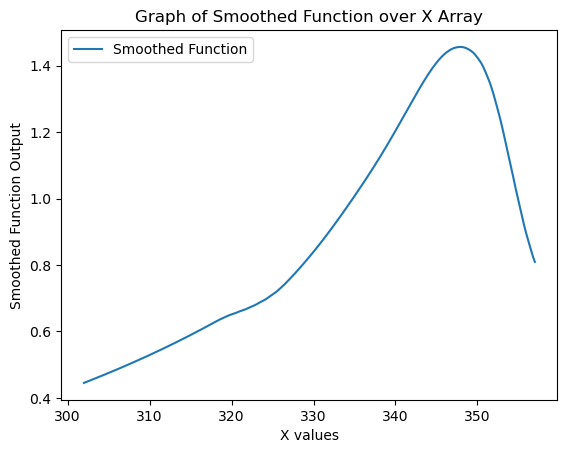

In [385]:
# Apply the smoothing function
gamma = 1  # Fixed gamma value
smoothed_values = smooth_function(general_payoff_power_rc, x_array, gamma)

# Plotting
plt.plot(x_array, smoothed_values, label='Smoothed Function')
plt.xlabel('X values')
plt.ylabel('Smoothed Function Output')
plt.title('Graph of Smoothed Function over X Array')
plt.legend()
plt.show()